## Introduction

AirSeaFluxCode is developed to provide an easy and accessible way to calculate turbulent surface fluxes (TSFs) from a small number of bulk variables and for a viariety of bulk algorithms. 

By running AirSeaFluxCode you can compare different bulk algorithms and to also investigate the effect choices within the implementation of each parameterisation have on the TSFs estimates. 


### Getting started

Let's first import the basic python packages we will need for reading in our input data, to perform basic statistics  and plotting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# first import all packages you might need
%matplotlib inline
import os
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import xarray_regrid
import numpy as np
import pandas as pd
import datetime
from codetiming import Timer
from glob import glob
from tabulate import tabulate
from scipy import ndimage
from src import AirSeaFluxCode

def np_multiply_many(list_of_arrays: list):
    """
        Performs np.multiply iteratively for a list of arrays (assumed to be the same shape)

    Args:
        list_of_arrays (list): list of arrays of the same shape

    Returns:
        np.ndarray : element-wise product of arrays in the list
    """
    
    for n, arr in enumerate(list_of_arrays):
        if n == 0:
            result = arr.copy()
        else:
            result = np.multiply(arr, result)
    
    return result

def get_dummy_global_dataset(resolution):
    
    return xr.Dataset(
        {
            'latitude': (['latitude'], np.arange(-90, 90 + resolution, resolution)),
            'longitude': (['longitude'], np.arange(0, 360, resolution)),
        }
    )
    
def potential_temperature(temperature: np.array, pressure: np.array, 
                          pressure_ref: float= 1014.0, 
                          kappa: float=0.286):

    return np.multiply(temperature, np.power(pressure_ref/pressure, kappa))

def potential_temperature_to_temperature(potential_temperature: np.array, pressure: np.array, 
                          pressure_ref: float= 1014.0, 
                          kappa: float=0.286):

    return np.multiply(potential_temperature, np.power(pressure/pressure_ref, kappa))

def calculate_density(pressure, temperature):
    # Ideal gas formula
    return pressure / (287*temperature)

def dataset_to_flux_dataframe(ds: xr.Dataset,
                              plevels: list=None):
    """Converts a dataset into a pandas dataset, in order to pass it to the air-sea flux calculation

    Args:
        ds (xr.Dataset): ERA5-like dataset to convert into a Pandas dataframe

    Returns:
        pd.DataFrame: Pandas dataframe
    """
    
    # It seems that AirSeaFluxCode expects downwards (not net) radiation fluxes
    flux_input_variables = ['2m_temperature', 
                            'mean_sea_level_pressure',  # Assumed to be in hPa
                            '10m_u_component_of_wind', 
                            '10m_v_component_of_wind',
                            'mean_surface_downward_short_wave_radiation_flux',
                            'mean_surface_downward_long_wave_radiation_flux',
                            'specific_humidity_surface'] # Assumed to be in kg/kg
                            
    
    if plevels is None: 
        plevels = [975, 1000]

    ds = ds[flux_input_variables].copy()
    ds['specific_humidity_surface'] = ds['specific_humidity_surface'] * 1000 # Convert to g/kg
    ds['wind_speed'] = np.sqrt(ds['10m_u_component_of_wind']**2 + ds['10m_v_component_of_wind']**2)

    df = ds.to_dataframe().reset_index()

    return df

def heuristic_boundary_layer_height(ds: xr.Dataset, 
                                    threshold: float=1.0,
                                    pressure_levels: list=None):
    
    """Heuristic method to calculate boundary layer height, based on the location that 
    potential temperature changes significantly
    
    Args:
        ds (xr.Dataset): Dataset containing temperature, geopotential, 2m_temperature, on pressure levels containing
        1000hPa, 975hPa, 950hPa, +...

    Returns:
        height_da, pressure_da: DataArrays containing boundary layer height on the grid, and the pressure level of the boundary height (to be used to update)
    """
    
    ds = ds.sortby('level', ascending=False)
    
    if pressure_levels is None:
        pressure_levels = [1000, 975, 950, 925, 900, 875, 850, 825, 800]
    else:
        pressure_levels = sorted(pressure_levels, reverse=True)
    
    da_pt = ds[f'temperature'].copy() 
    for p in pressure_levels:
        da_pt.loc[{'level': p}] = potential_temperature(temperature=ds['temperature'].sel(level=p), pressure=p)

    # Calculate boundary layer heights
    
    height_da = xr.ones_like(ds['2m_temperature']) * np.nan
    pressure_da = xr.ones_like(ds['2m_temperature']) * np.nan

    for n, p in enumerate([1014] + list(pressure_levels)):
        if n == 0:
            pressure_level_da = xr.ones_like(ds['2m_temperature']) * p
        else:
            pressure_level_da = xr.ones_like(ds['2m_temperature']) * p
            
        if n == 0:
            
            large_diff_2m_1000 = np.abs(ds['2m_temperature'] - da_pt.sel(level=1000)) > threshold
            large_diff_2m_975 = np.abs(ds['2m_temperature'] - da_pt.sel(level=975)) > threshold
            large_diff_2m_950 = np.abs(ds['2m_temperature'] - da_pt.sel(level=975)) > threshold
            
            large_diff_1000_975 = np.abs(da_pt.sel(level=1000) - da_pt.sel(level=975)) > threshold

            large_diff_975_950 = np.abs(da_pt.sel(level=975) - da_pt.sel(level=950)) > threshold
            large_diff_950_925 = np.abs(da_pt.sel(level=950) - da_pt.sel(level=925)) > threshold
            
            check_1000hpa_positive = ds[f'geopotential'].sel(level=1000) > 0
            check_975hpa_positive = ds[f'geopotential'].sel(level=975) > 0
            
            logical_condition_1 = np.logical_and(check_1000hpa_positive, np.logical_and(large_diff_2m_1000, large_diff_1000_975))
            logical_condition_2 = np.logical_and(check_975hpa_positive, np.logical_and(large_diff_2m_975, large_diff_975_950))
            logical_condition_3 = np.logical_and(large_diff_2m_950, large_diff_950_925)
            
            # Use height halfway between 10m and the level of the first positive geopotential
            height_to_use = xr.where(check_1000hpa_positive, 0.5*(10.0 + ds['geopotential'].sel(level=1000)), xr.where(check_975hpa_positive, 0.5*(10.0 + ds['geopotential'].sel(level=975)), 0.5*(10.0 + ds['geopotential'].sel(level=950))))
            # height_to_use = 100
            
            height_da = xr.where(np.logical_or(np.logical_or(logical_condition_1, logical_condition_2), logical_condition_3), height_to_use, np.nan)
            pressure_da = xr.where(np.logical_or(np.logical_or(logical_condition_1, logical_condition_2), logical_condition_3), pressure_level_da, np.nan)
            
        elif n == len(pressure_levels):
            values_are_null = height_da.isnull()
            height_da = xr.where(values_are_null, ds['geopotential'].sel(level=p) / 9.81, height_da)
            pressure_da = xr.where(values_are_null, pressure_level_da, pressure_da)
        else:
            
            large_diff_here = np.abs(da_pt.sel(level=p) - da_pt.sel(level=pressure_levels[n])) > threshold
            check_positive = ds['geopotential'].sel(level=p) > 0

            values_are_null = height_da.isnull()
            
            logical_condition =  np.logical_and(check_positive, np.logical_and(large_diff_here, values_are_null))
            
            height_da = xr.where(logical_condition, 0.5*(ds['geopotential'].sel(level=p) + ds['geopotential'].sel(level=pressure_levels[n]))/ 9.81, height_da)
            # height_da = xr.where(logical_condition, ds['geopotential'].sel(level=p)/ 9.81, height_da)
            pressure_da = xr.where(logical_condition, pressure_level_da, pressure_da)

    return height_da, pressure_da


    

## Air sea flux code on gridded data

In [4]:
# TODO: precip needs to be aggregated

In [5]:
# 1 second per 6 hours in SYPD
secs_per_6hr_step = 2
secs_per_day = secs_per_6hr_step * 4
secs_per_year = secs_per_day*365
print(secs_per_year / 60)
sypd = (24*60*60) / secs_per_year
print(sypd)

48.666666666666664
29.589041095890412


In [6]:
year = 2016
month = 1
day = 1
hr = 12

dt = datetime.datetime(year,month,day, hour=hr)

In [7]:
sst_da = xr.load_dataarray(f"/Users/bobbyantonio/repos/AirSeaFluxCode/sample_era5_data/era5_sea_surface_temperature_{dt.strftime('%Y%m%d')}.nc").isel(time=0)

# Regrid to 2 degrees
target_2_degree_ds = get_dummy_global_dataset(2.0)
# sst_da = sst_da.regrid.linear(target_2_degree_ds).sel(latitude=np.arange(-90, 90,2)) # Subselecting latitude to be consistent with saved data

latitude_vals = sst_da['latitude'].values
longitude_vals = sst_da['longitude'].values

sst_array = sst_da.values
sst_shape = sst_array.shape

latitude_array = np.broadcast_to(np.array(latitude_vals).reshape(-1,1), sst_shape)
longitude_array = np.broadcast_to(np.array(longitude_vals).reshape(1,-1), sst_shape)

sea_mask = xr.where(~sst_da.isnull(), True, False)
sst_mask = ~np.isnan(sst_array)
sea_mask_df = sea_mask.to_dataframe().reset_index()[['sst']]

lat_vals = latitude_array[sst_mask]
lon_vals = longitude_array[sst_mask]

sea_points = np.array(list(zip(lat_vals, lon_vals)))

In [19]:

glob_str = f"/Users/bobbyantonio/repos/AirSeaFluxCode/sample_era5_data/*{dt.strftime('%Y%m%d')}.nc"
fps = glob(glob_str)

var_name_lookup = {'z': 'geopotential', 'q': 'specific_humidity', 't': 'temperature'}

surface_fps = [fp for fp in fps if 'hPa' not in fp]
surface_ds = xr.merge([xr.load_dataset(fp) for fp in surface_fps])


In [20]:
def convert_era5_file(fp):

    ds = xr.load_dataset(fp)
    print(fp)
    if 'valid_time' in ds.coords:
        ds = ds.rename({'valid_time': 'time'})

    ds = ds.sortby('latitude')
    return ds

In [21]:

# Means of 
surface_ds['surface_wind_magnitude'] = np.sqrt(surface_ds['u10']**2 + surface_ds['v10']**2)
surface_ds['instantaneous_surface_stress_magnitude'] = np.sqrt(surface_ds['iews']**2 + surface_ds['inss']**2)
surface_ds['mean_surface_stress_magnitude'] = np.sqrt(surface_ds['avg_iews']**2 + surface_ds['avg_inss']**2)

for var in ['ishf', 'msshf', 'mslhf',  'avg_iews', 'avg_inss']:
    surface_ds[f'{var}_6hr'] = surface_ds[var].sel(time=[dt + pd.Timedelta(n, 'h') for n in range(1, 7)]).groupby(['latitude', 'longitude']).mean(...).expand_dims(dim={'time': 1}).assign_coords({'time': [dt]}).compute()

surface_ds['msnswrf'] = surface_ds['msnswrf'].fillna(0)

# Convert to hPa
surface_ds['msl'] = surface_ds['msl'] / 100

surface_ds_t0 = surface_ds.sel(time=dt)

plevel_fps = [fp for fp in fps if 'hPa' in fp]

plevel_ds = []
for var in ['z', 'q', 't']:
    tmp_fps = [fp for fp in plevel_fps if var_name_lookup[var] in fp]
    if len(tmp_fps) > 0:
        tmp_ds = xr.concat([xr.load_dataset(fp).drop_vars('expver') for fp in sorted(tmp_fps)], dim='pressure_level')

        plevel_ds.append(tmp_ds)
plevel_ds = xr.merge(plevel_ds)


# Interpolate humidity to surface
plevel_ds['specific_humidity_surface'] = plevel_ds['q'].sel(pressure_level=1000) + (plevel_ds['q'].sel(pressure_level=1000) - plevel_ds['q'].sel(pressure_level=975)) * (surface_ds['msl'] - 1000) / 25

ds = xr.merge([surface_ds_t0, plevel_ds]).sel(time=dt)
                                           
                                           
# ds['ewss'] = ds['ewss'] / (60*60) # Convert from integrated stress to mean stress
# ds['ewss'] = ds['nsss'] / (60*60)

ds = ds.rename({'u10': '10m_u_component_of_wind',
                'v10': '10m_v_component_of_wind',
                'z': 'geopotential',
                'q': 'specific_humidity',
                'msl': 'mean_sea_level_pressure',
                't2m': '2m_temperature',
                'skt': 'skin_temperature',
                't': 'temperature',
                'sst': 'sea_surface_temperature',
                'msnswrf': 'mean_surface_net_short_wave_radiation_flux',
                'msdwswrf': 'mean_surface_downward_short_wave_radiation_flux',
                'msdwlwrf': 'mean_surface_downward_long_wave_radiation_flux',
                'avg_snlwrf': 'mean_surface_net_long_wave_radiation_flux',
                'avg_iews': 'mean_eastward_turbulent_surface_stress',
                'avg_inss': 'mean_northward_turbulent_surface_stress',
                'avg_iews_6hr': 'mean_eastward_turbulent_surface_stress_6hr',
                'avg_inss_6hr': 'mean_northward_turbulent_surface_stress_6hr',
                'p140209': 'air_density_over_ocean',
                'flsr': 'forecast_logarithm_of_surface_roughness_for_heat',
                'fal': 'forecast_albedo',
                'pressure_level': 'level'}).drop_vars('expver').drop_vars('number')

ds['mean_surface_stress_magnitude_6hr'] = np.sqrt(ds['mean_eastward_turbulent_surface_stress_6hr']**2 + ds['mean_northward_turbulent_surface_stress_6hr']**2)

sea_surface_ds = ds[['skin_temperature', 'sea_surface_temperature']]

In [10]:
# # Createa a 2 degrees version. Just using bilinear for now to see speed
target_dataset = xr.Dataset(
    {
        'latitude': (['latitude'], np.arange(-90, 90 + 2, 2)),
        'longitude': (['longitude'], np.arange(0, 360, 2)),
    }
)

ds_2deg = ds.unify_chunks().regrid.linear(target_dataset)

df_2deg = ds_2deg.to_dataframe().reset_index()

df_2deg = df_2deg[~np.isnan(df_2deg['sea_surface_temperature'])].reset_index()
df_2deg.head()

index  latitude  longitude  level                time  \
0  10602       -78        196  800.0 2016-01-01 12:00:00   
1  10603       -78        196  825.0 2016-01-01 12:00:00   
2  10604       -78        196  850.0 2016-01-01 12:00:00   
3  10605       -78        196  875.0 2016-01-01 12:00:00   
4  10606       -78        196  900.0 2016-01-01 12:00:00   

   sea_surface_temperature      slhf      zust  air_density_over_ocean  \
0               272.131592 -148751.0  0.428447                     NaN   
1               272.131592 -148751.0  0.428447                     NaN   
2               272.131592 -148751.0  0.428447                     NaN   
3               272.131592 -148751.0  0.428447                     NaN   
4               272.131592 -148751.0  0.428447                     NaN   

   10m_u_component_of_wind  ...  ishf_6hr  msshf_6hr  mslhf_6hr  \
0                -8.179406  ... -5.616374   3.181885  -5.183594   
1                -8.179406  ... -5.616374   3.181885  -5.183594   
2                -8.179406  ... -5.616374   3.181885  -5.183594   
3                -8.179406  ... -5.616374   3.181885  -5.183594   
4                -8.179406  ... -5.616374   3.181885  -5.183594   

   mean_eastward_turbulent_surface_stress_6hr  \
0                                   -0.090023   
1                                   -0.090023   
2                                   -0.090023   
3                                   -0.090023   
4                                   -0.090023   

   mean_northward_turbulent_surface_stress_6hr  geopotential  \
0                                     0.035469  14655.566406   
1                                     0.035469  12334.160156   
2                                     0.035469  10068.437500   
3                                     0.035469   7857.730469   
4                                     0.035469   5702.589844   

   specific_humidity  temperature  specific_humidity_surface  \
0                NaN   261.704468                   0.002595   
1                NaN   263.330963                   0.002595   
2                NaN   264.805786                   0.002595   
3                NaN   265.804901                   0.002595   
4                NaN   266.404480                   0.002595   

   mean_surface_stress_magnitude_6hr  
0                           0.096759  
1                           0.096759  
2                           0.096759  
3                           0.096759  
4                           0.096759  

[5 rows x 44 columns]

### Calculate ice fluxes

Based on the Core bulk formulae used in NEMO 3.6


In [27]:
def solar_flux_over_ice(atmosphere_ds, ice_ds):
    ocean_albedo = 0.066
    total_solar_flux = (1/(1-ocean_albedo)) * atmosphere_ds['mean_surface_downward_short_wave_radiation_flux'] * (1 - ice_ds['ice_albedo'])
    total_solar_flux.name = 'short_wave_radiation_flux_ice'
    return total_solar_flux

def momentum_flux_over_ice(ds):
    air_density = 1.22
    
    C_ice = 1.4e-3  # Heat transfer coefficient for ice, assumed constant
    taux = air_density * C_ice * ds['relative_wind_speed_ice'] * ds['relative_wind_speed_ice_u']
    tauy = air_density * C_ice * ds['relative_wind_speed_ice'] * ds['relative_wind_speed_ice_v']
    
    taux.name = 'momentum_flux_u_ice'
    tauy.name = 'momentum_flux_v_ice'
    
    return taux, tauy

def non_solar_fluxes_ice(atmosphere_ds, ice_ds):
    
    stefan_boltzmann = 5.67e-8
    air_density = 1.22
    specific_heat_capacity_air = 1005.0  # J/(kg*K)
    C_ice = 1.4e-3  # Heat transfer coefficient for ice, assumed constant
    Ls = 2.839e6  # Latent heat of sublimation for ice, J/kg
    wind_speed = np.sqrt(atmosphere_ds['10m_u_component_of_wind']**2 + atmosphere_ds['10m_v_component_of_wind']**2)
    
    # Net long wave radiation fluxes
    q_long_wave = 0.95 + ( atmosphere_ds['mean_surface_downward_long_wave_radiation_flux'] - stefan_boltzmann * ice_ds['sea_ice_temperature']**4 )
    q_long_wave.name = 'net_long_wave_radiation_flux_ice'

    # Turbulent fluxes
    # Sensible heat flux; note that it is defined as positive when heat is transferred from the air to the ice
    q_sensible_heat = air_density * specific_heat_capacity_air * C_ice * wind_speed * (atmosphere_ds['2m_temperature'] - ice_ds['sea_ice_temperature'])
    q_sensible_heat.name = 'sensible_heat_flux_ice'

    # Latent heat flux; note that it is defined as positive when water vapor is transferred from the air to the ice
    latent_heat_flux = -1 * air_density * Ls * C_ice * wind_speed *  ( 11637800 * np.exp( -5897.8 / ice_ds['sea_ice_temperature'] ) / air_density - atmosphere_ds['specific_humidity_surface'] )
    latent_heat_flux = xr.where(latent_heat_flux > 0, 0, latent_heat_flux)  # Set positive fluxes to zero (in line with NEMO 3.6)
    latent_heat_flux.name = 'latent_heat_flux_ice'
    
    total_non_solar_flux = q_long_wave + q_sensible_heat + latent_heat_flux
    total_non_solar_flux.name = 'total_non_solar_flux_ice'
    
    return xr.merge([
        total_non_solar_flux,
        q_long_wave,
        q_sensible_heat,
        latent_heat_flux])

In [137]:
stefan_boltzmann = 5.67e-8
air_density = 1.22
specific_heat_capacity_air = 1005.0  # J/(kg*K)
C_ice = 1.4e-3  # Heat transfer coefficient for ice, assumed constant
Ls = 2.839e6  # Latent heat of sublimation for ice, J/kg
wind_speed = np.sqrt(ds['10m_u_component_of_wind']**2 + ds['10m_v_component_of_wind']**2)

latent_heat_flux = -1* air_density * Ls * C_ice * wind_speed *  ( 11637800 * np.exp( -5897.8 / ice_ds['sea_ice_temperature'] ) / air_density - ds['specific_humidity_surface'] )
latent_heat_flux = xr.where(latent_heat_flux > 0, 0, latent_heat_flux)  # Set positive fluxes to zero (in line with NEMO 3.6)
latent_heat_flux.name = 'latent_heat_flux_ice'

In [15]:
def ice_fluxes(atmosphere_ds, ice_ds):
    # Solar fluxes over the ice

    # Short wave radiation fluxes
    ocean_albedo = 0.066
    stefan_boltzmann = 5.67e-8
    total_solar_flux = (1/(1-ocean_albedo)) * atmosphere_ds['mean_surface_downward_short_wave_radiation_flux'] * (1 - ice_ds['ice_albedo'])
    total_solar_flux.name = 'short_wave_radiation_flux_ice'
    
    # Net long wave radiation fluxes
    q_long_wave = 0.95 + ( atmosphere_ds['mean_surface_downward_long_wave_radiation_flux'] - stefan_boltzmann * ice_ds['sea_ice_temperature']**4 )

    # Turbulent fluxes
    # sensible heat flux
    air_density = 1.22
    specific_heat_capacity_air = 1005.0  # J/(kg*K)
    C_ice = 1.4e-3  # Heat transfer coefficient for ice, assumed constant
    Ls = 2.839e6  # Latent heat of sublimation for ice, J/kg
    wind_speed = np.sqrt(atmosphere_ds['10m_u_component_of_wind']**2 + atmosphere_ds['10m_v_component_of_wind']**2)

    # Sensible heat flux; note that it is defined as positive when heat is transferred from the air to the ice
    q_sensible_heat = air_density * specific_heat_capacity_air * C_ice * wind_speed * (atmosphere_ds['2m_temperature'] - ice_ds['sea_ice_temperature'])
    q_sensible_heat.name = 'sensible_heat_flux_ice'

    # Latent heat flux; note that it is defined as positive when water vapor is transferred from the air to the ice
    latent_heat_flux = -1* air_density * Ls * C_ice * wind_speed *  ( 11637800 * np.exp( -5897.8 / ice_ds['sea_ice_temperature'] ) / air_density - atmosphere_ds['specific_humidity_surface'] )
    latent_heat_flux = xr.where(latent_heat_flux > 0, 0, latent_heat_flux)  # Set positive fluxes to zero (in line with NEMO 3.6)
    latent_heat_flux.name = 'latent_heat_flux_ice'
    
    total_non_solar_flux = q_long_wave + q_sensible_heat + latent_heat_flux
    total_non_solar_flux.name = 'total_non_solar_flux_ice'

    ice_flux_ds = xr.merge([
        total_solar_flux,
        total_non_solar_flux,
        q_sensible_heat,
        latent_heat_flux])
    
    return ice_flux_ds

In [26]:
ice_ds = ds[['skin_temperature', 'forecast_albedo']].rename({'skin_temperature': 'sea_ice_temperature', 'forecast_albedo': 'ice_albedo'})
ice_mask = ds['siconc'] > 0.1

ds['relative_wind_speed_ice_u'] = ds['10m_u_component_of_wind']
ds['relative_wind_speed_ice_v'] = ds['10m_v_component_of_wind']
ds['relative_wind_speed_ice'] = np.sqrt(ds['relative_wind_speed_ice_u']**2 + ds['relative_wind_speed_ice_v']**2)

ice_ds = ice_ds.where(ice_mask)

Text(400.7790404040403, 0.5, 'Latitude')

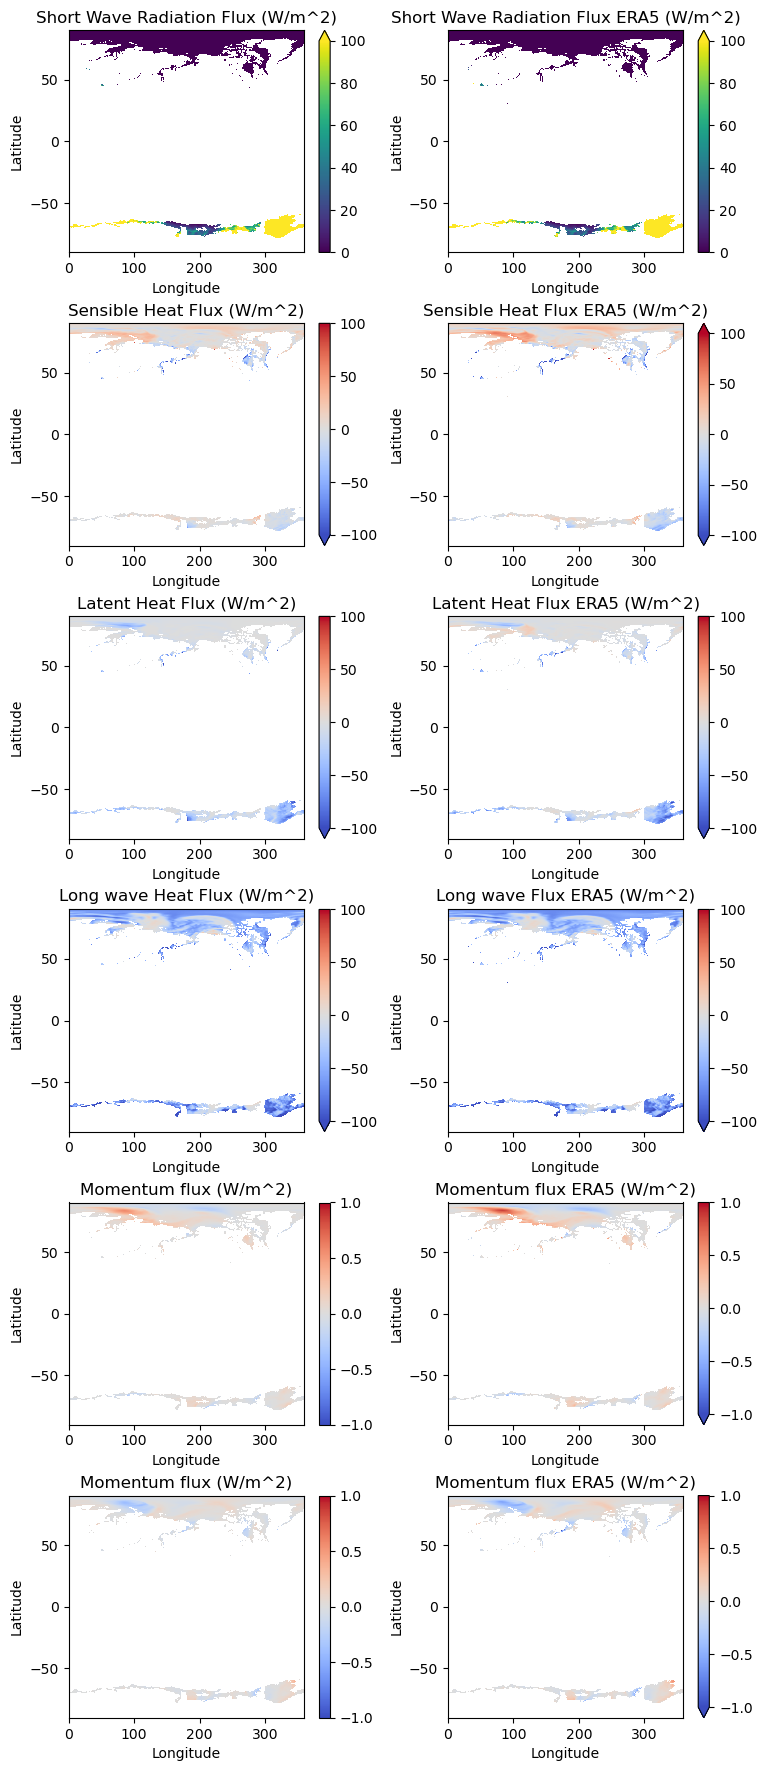

In [35]:
tauu, tauv = momentum_flux_over_ice(ds)

ice_flux_ds = xr.merge([solar_flux_over_ice(ds, ice_ds), non_solar_fluxes_ice(ds, ice_ds),tauu, tauv])

nrows= 6
fig, ax = plt.subplots(nrows,2, figsize=(2*4,3*nrows))
fig.tight_layout(pad=3.0)

xr.where(ice_mask, ice_flux_ds['short_wave_radiation_flux_ice'], np.nan).plot(ax=ax[0,0], vmin=0, vmax=100, cmap='viridis')
ax[0,0].set_title('Short Wave Radiation Flux (W/m^2)')
ax[0,0].set_xlabel('Longitude')
ax[0,0].set_ylabel('Latitude')          

xr.where(ice_mask, ds['mean_surface_net_short_wave_radiation_flux'], np.nan).plot(ax=ax[0,1], vmin=0, vmax=100, cmap='viridis')
ax[0,1].set_title('Short Wave Radiation Flux ERA5 (W/m^2)')
ax[0,1].set_xlabel('Longitude')
ax[0,1].set_ylabel('Latitude')        

xr.where(ice_mask, ice_flux_ds['sensible_heat_flux_ice'], np.nan).plot(ax=ax[1,0], vmin=-100, vmax=100, cmap='coolwarm')
ax[1,0].set_title('Sensible Heat Flux (W/m^2)') 
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Latitude')

xr.where(ice_mask, ds['msshf'], np.nan).plot(ax=ax[1,1], vmin=-100, vmax=100, cmap='coolwarm')
ax[1,1].set_title('Sensible Heat Flux ERA5 (W/m^2)') 
ax[1,1].set_xlabel('Longitude')
ax[1,1].set_ylabel('Latitude')

xr.where(ice_mask, ice_flux_ds['latent_heat_flux_ice'], np.nan).plot(ax=ax[2,0], vmin=-100, vmax=100,  cmap='coolwarm')
ax[2,0].set_title('Latent Heat Flux (W/m^2)')
ax[2,0].set_xlabel('Longitude')
ax[2,0].set_ylabel('Latitude')

xr.where(ice_mask, ds['mslhf'], np.nan).plot(ax=ax[2,1], vmin=-100, vmax=100, cmap='coolwarm')
ax[2,1].set_title('Latent Heat Flux ERA5 (W/m^2)')
ax[2,1].set_xlabel('Longitude')
ax[2,1].set_ylabel('Latitude')

xr.where(ice_mask, ice_flux_ds['net_long_wave_radiation_flux_ice'], np.nan).plot(ax=ax[3,0], vmin=-100, vmax=100, cmap='coolwarm')
ax[3,0].set_title('Long wave Heat Flux (W/m^2)')
ax[3,0].set_xlabel('Longitude')
ax[3,0].set_ylabel('Latitude')

xr.where(ice_mask, ds['mean_surface_net_long_wave_radiation_flux'], np.nan).plot(ax=ax[3,1], vmin=-100, vmax=100, cmap='coolwarm')
ax[3,1].set_title('Long wave Flux ERA5 (W/m^2)')
ax[3,1].set_xlabel('Longitude')
ax[3,1].set_ylabel('Latitude')

xr.where(ice_mask, ice_flux_ds['momentum_flux_u_ice'], np.nan).plot(ax=ax[4,0],vmin=-1, vmax=1,cmap='coolwarm')
ax[4,0].set_title('Momentum flux (W/m^2)')
ax[4,0].set_xlabel('Longitude')
ax[4,0].set_ylabel('Latitude')

xr.where(ice_mask, ds['mean_eastward_turbulent_surface_stress'], np.nan).plot(ax=ax[4,1], vmin=-1, vmax=1,cmap='coolwarm')
ax[4,1].set_title('Momentum flux ERA5 (W/m^2)')
ax[4,1].set_xlabel('Longitude')
ax[4,1].set_ylabel('Latitude')

xr.where(ice_mask, ice_flux_ds['momentum_flux_v_ice'], np.nan).plot(ax=ax[5,0], vmin=-1, vmax=1,cmap='coolwarm')
ax[5,0].set_title('Momentum flux (W/m^2)')
ax[5,0].set_xlabel('Longitude')
ax[5,0].set_ylabel('Latitude')

xr.where(ice_mask, ds['mean_northward_turbulent_surface_stress'], np.nan).plot(ax=ax[5,1], vmin=-1, vmax=1,cmap='coolwarm')
ax[5,1].set_title('Momentum flux ERA5 (W/m^2)')
ax[5,1].set_xlabel('Longitude')
ax[5,1].set_ylabel('Latitude')


In [11]:
df = dataset_to_flux_dataframe(ds)
sea_surface_df = sea_surface_ds['sea_surface_temperature'].to_dataframe().reset_index()
sea_surface_df = sea_surface_df[sea_mask_df['sst']]
sea_surface_df = sea_surface_df

out_vars = ("tau", "sensible", "latent", "cd", "cp", "ct", "cq", "rho", 'dter', 'dqer', 'dtwl', 'rh', 'lv', 'qsea')

flux_df = df[sea_mask_df['sst']].reset_index()

res_sst = AirSeaFluxCode.AirSeaFluxCode(spd=flux_df['wind_speed'].copy().to_numpy(), 
                     T=flux_df['2m_temperature'].copy().to_numpy(), 
                     SST=sea_surface_df['sea_surface_temperature'].to_numpy(), 
                     SST_fl="bulk", 
                     meth="ecmwf", 
                     lat=flux_df['latitude'].to_numpy(),
                     hin=np.array([10, 2]), 
                     hum=('q', flux_df['specific_humidity_surface'].copy().to_numpy()), 
                     hout=10,
                     maxiter=50,
                     P=flux_df['mean_sea_level_pressure'].copy().to_numpy(), 
                     cskin=1, 
                     Rs=flux_df['mean_surface_downward_short_wave_radiation_flux'].copy().to_numpy(),
                     Rl=flux_df['mean_surface_downward_long_wave_radiation_flux'].copy().to_numpy(),
                     tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], 
                     L="tsrv", 
                     wl=1,
                     gust=[4, 1.2, 600, 0.01],
                     out_var = out_vars,
                     out=0)

res_sst_df = pd.concat([flux_df[['latitude', 'longitude']], res_sst], axis=1)
full_sst_df = df[['latitude', 'longitude']].merge(res_sst_df, on=['latitude', 'longitude'], how='left')
res_sst_ds = full_sst_df.set_index(['latitude', 'longitude']).to_xarray()

# TODO: try using ffill instead (bit slower)
for var in out_vars:

    non_zero_points = np.logical_and(sea_mask == 1, np.logical_or(ds['siconc'].isnull(), ds['siconc'] <0.1))
    if var in ['latent', 'rho', 'sensible', 'tau', 'ct']:
        print(10*'*')
        print(f'Max {var}: {np.nanmax(res_sst_ds[var]).item()}')
        print(f'Min {var}: {np.nanmin(res_sst_ds[var]).item()}')
        print(f'Mean {var}: {np.nanmean(res_sst_ds[var]).item()}')
        print(f'Num NaN {var} in output dataframe: ', np.isnan(xr.where(non_zero_points, res_sst_ds['ct'], 0)).sum().item())
    
    # if var in  ["tau", "sensible", "latent"]:
    #     # Fill NaNs, set land points to 0 flux, and set sea-ice points to 0 flux
    #     res_sst_ds[var] = xr.where(non_zero_points, res_sst_ds[var].fillna(res_sst_ds[var].mean().item()), 0)
    # else:
    #     res_sst_ds[var] = res_sst_ds[var].fillna(res_sst_ds[var].mean().item())
             
print('Num NaN tau in final dataset: ', res_sst_ds['ct'].isnull().sum().item(), ' / ', res_sst_ds['ct'].size)

# Calculate boundary layer height

**********
Max tau: 1.81997105862548
Min tau: 3.5221004120708355e-16
Mean tau: 0.13054941879828433
Num NaN tau in output dataframe:  879
**********
Max sensible: 116.48451636254497
Min sensible: -614.9509001065688
Mean sensible: -20.706027685445427
Num NaN sensible in output dataframe:  879
**********
Max latent: 133.15315738190458
Min latent: -663.2835752607112
Mean latent: -105.02918745755687
Num NaN latent in output dataframe:  879
**********
Max ct: 0.0032075020913700136
Min ct: 3.556426935551779e-15
Mean ct: 0.0012964062515155859
Num NaN ct in output dataframe:  879
**********
Max rho: 1.42898990575752
Min rho: 1.1198802943319504
Mean rho: 1.2191647230580342
Num NaN rho in output dataframe:  879
Num NaN tau in final dataset:  408782  /  1038240


In [11]:
height_da, pressure_da = heuristic_boundary_layer_height(ds)
height_da = np.clip(height_da, a_min=200, a_max=None)

In [19]:

# df = dataset_to_flux_dataframe(ds)
# sea_surface_df = sea_surface_ds['skin_temperature'].to_dataframe().reset_index()
# sea_surface_df = sea_surface_df[sea_mask_df['sst']]

# flux_df = df[sea_mask_df['sst']].reset_index()


# res_ssst = AirSeaFluxCode.AirSeaFluxCode(spd=flux_df['wind_speed'].to_numpy(), 
#                      T=flux_df['2m_temperature'].to_numpy(), 
#                      SST=sea_surface_df['skin_temperature'].to_numpy(), 
#                      SST_fl="skin", 
#                      meth="ecmwf", 
#                      lat=flux_df['latitude'].to_numpy(),
#                      hin=np.array([10, 2]), 
#                      hum=('q', flux_df['specific_humidity_surface'].to_numpy()), 
#                      hout=10,
#                      maxiter=20,
#                      P=flux_df['mean_sea_level_pressure'].to_numpy(), 
#                      cskin=0, 
#                     #  Rs=flux_df['msdwswrf'].to_numpy(),
#                      tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], 
#                      L="tsrv", 
#                      wl=0,
#                      out_var = ("tau", "sensible", "latent", "cd", "cp", "rho", "ct", "usr", "ct", "ct10n"))
# res_ssst_df = pd.concat([flux_df[['latitude', 'longitude']], res_ssst], axis=1)
# full_ssst_df = df[['latitude', 'longitude']].merge(res_ssst_df, on=['latitude', 'longitude'], how='left')
# res_ssst_ds = full_ssst_df.set_index(['latitude', 'longitude']).to_xarray()

# # TODO: try using ffill instead (bit slower)
# for var in ["tau", "sensible", "latent", "cd", "cp", "rho"]:

#     if var in  ["tau", "sensible", "latent"]:
#         # Fill NaNs, set land points to 0 flux, and set sea-ice points to 0 flux
#         res_ssst_ds[var] = xr.where(sea_mask, res_ssst_ds[var].fillna(res_ssst_ds[var].mean().item()), 0)
#     else:
#         res_ssst_ds[var] = res_ssst_ds[var].fillna(res_ssst_ds[var].mean().item())
             
# print('Num NaN tau in output dataframe: ', res_ssst_df['tau'].isna().sum(), ' / ', len(res_ssst_df['tau']))  
# print('Num NaN tau in final dataset: ', res_ssst_ds['tau'].isnull().sum().item(), ' / ', res_ssst_ds['tau'].size)

In [20]:
# Sanity check results compared to ERA5
funcs = {'mean': lambda x: x.mean().item(), 'max': lambda x: x.max().item(), 'min': lambda x: x.min().item()}

for k, func in funcs.items():
    
    print(f"{k} for ERA5: {func(ds['msshf'])}")
    print(f"{k} for ERA5 6hr: {func(ds['msshf_6hr'])}")
    print(f"{k} for AirSeaFlux: {func(res_sst_ds['sensible'])}")

mean for ERA5: -13.86768913269043
mean for ERA5 6hr: -8.619685173034668
mean for AirSeaFlux: -7.263412894864545
max for ERA5: 213.247802734375
max for ERA5 6hr: 181.713134765625
max for AirSeaFlux: 116.48451636254497
min for ERA5: -587.627197265625
min for ERA5 6hr: -617.302490234375
min for AirSeaFlux: -329.9512799909364


In [15]:
# res_2deg = AirSeaFluxCode(spd=df_2deg['wind_speed'].to_numpy(), 
#                      T=df_2deg['t2m'].to_numpy(), 
#                      SST=df_2deg['skt'].to_numpy(), 
#                      SST_fl="skin", 
#                      meth="ecmwf", 
#                      lat=df_2deg['latitude'].to_numpy(),
#                      hin=np.array([10, 2]), 
#                      hum=('q', df_2deg['q_surface'].to_numpy()), 
#                      hout=10,
#                      maxiter=50,
#                      P=df_2deg['msl'].to_numpy(), 
#                      cskin=0, 
#                      Rs=df_2deg['msdwswrf'],
#                      tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], 
#                      L="tsrv", 
#                      wl=1,
#                      out_var = ("tau", "sensible", "latent", "cd", "rho", "uref"))
# res_2deg = pd.concat([df_2deg[['latitude', 'longitude']], res_2deg], axis=1)
# res_2deg_ds = res_2deg.set_index(['latitude', 'longitude']).to_xarray()

# print('Num nan tau on sea: ', res_2deg_ds['tau'].isna().sum(), ' / ', len(res_2deg))

Text(0.5, 1.0, 'ERA5 mean Sensible (6hr)')

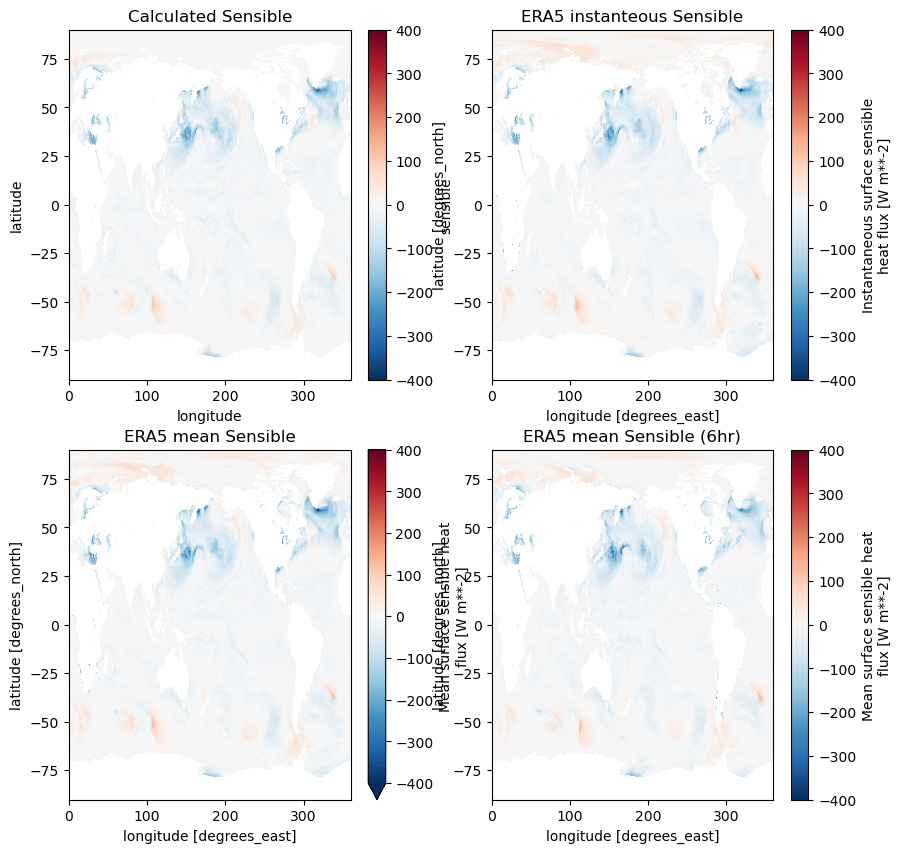

In [12]:
num_rows = 2
num_cols = 2

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
res_sst_ds['sensible'].where(sea_mask).plot.imshow(cmap='RdBu_r', ax=ax[0,0], vmin=-400, vmax=400)
ax[0,0].set_title('Calculated Sensible')

sshf_da = ds['ishf'].where(sea_mask)
sshf_da.plot.imshow(ax=ax[0,1], vmin=-400, vmax=400, cmap='RdBu_r',)
ax[0,1].set_title('ERA5 instanteous Sensible')

sshf_da = ds['msshf'].where(sea_mask)
sshf_da.plot.imshow(ax=ax[1,0], vmin=-400, vmax=400, cmap='RdBu_r',)
ax[1,0].set_title('ERA5 mean Sensible')

sshf_da = ds['msshf_6hr'].where(sea_mask)
sshf_da.plot.imshow(ax=ax[1,1], vmin=-400, vmax=400, cmap='RdBu_r',)
ax[1,1].set_title('ERA5 mean Sensible (6hr)')

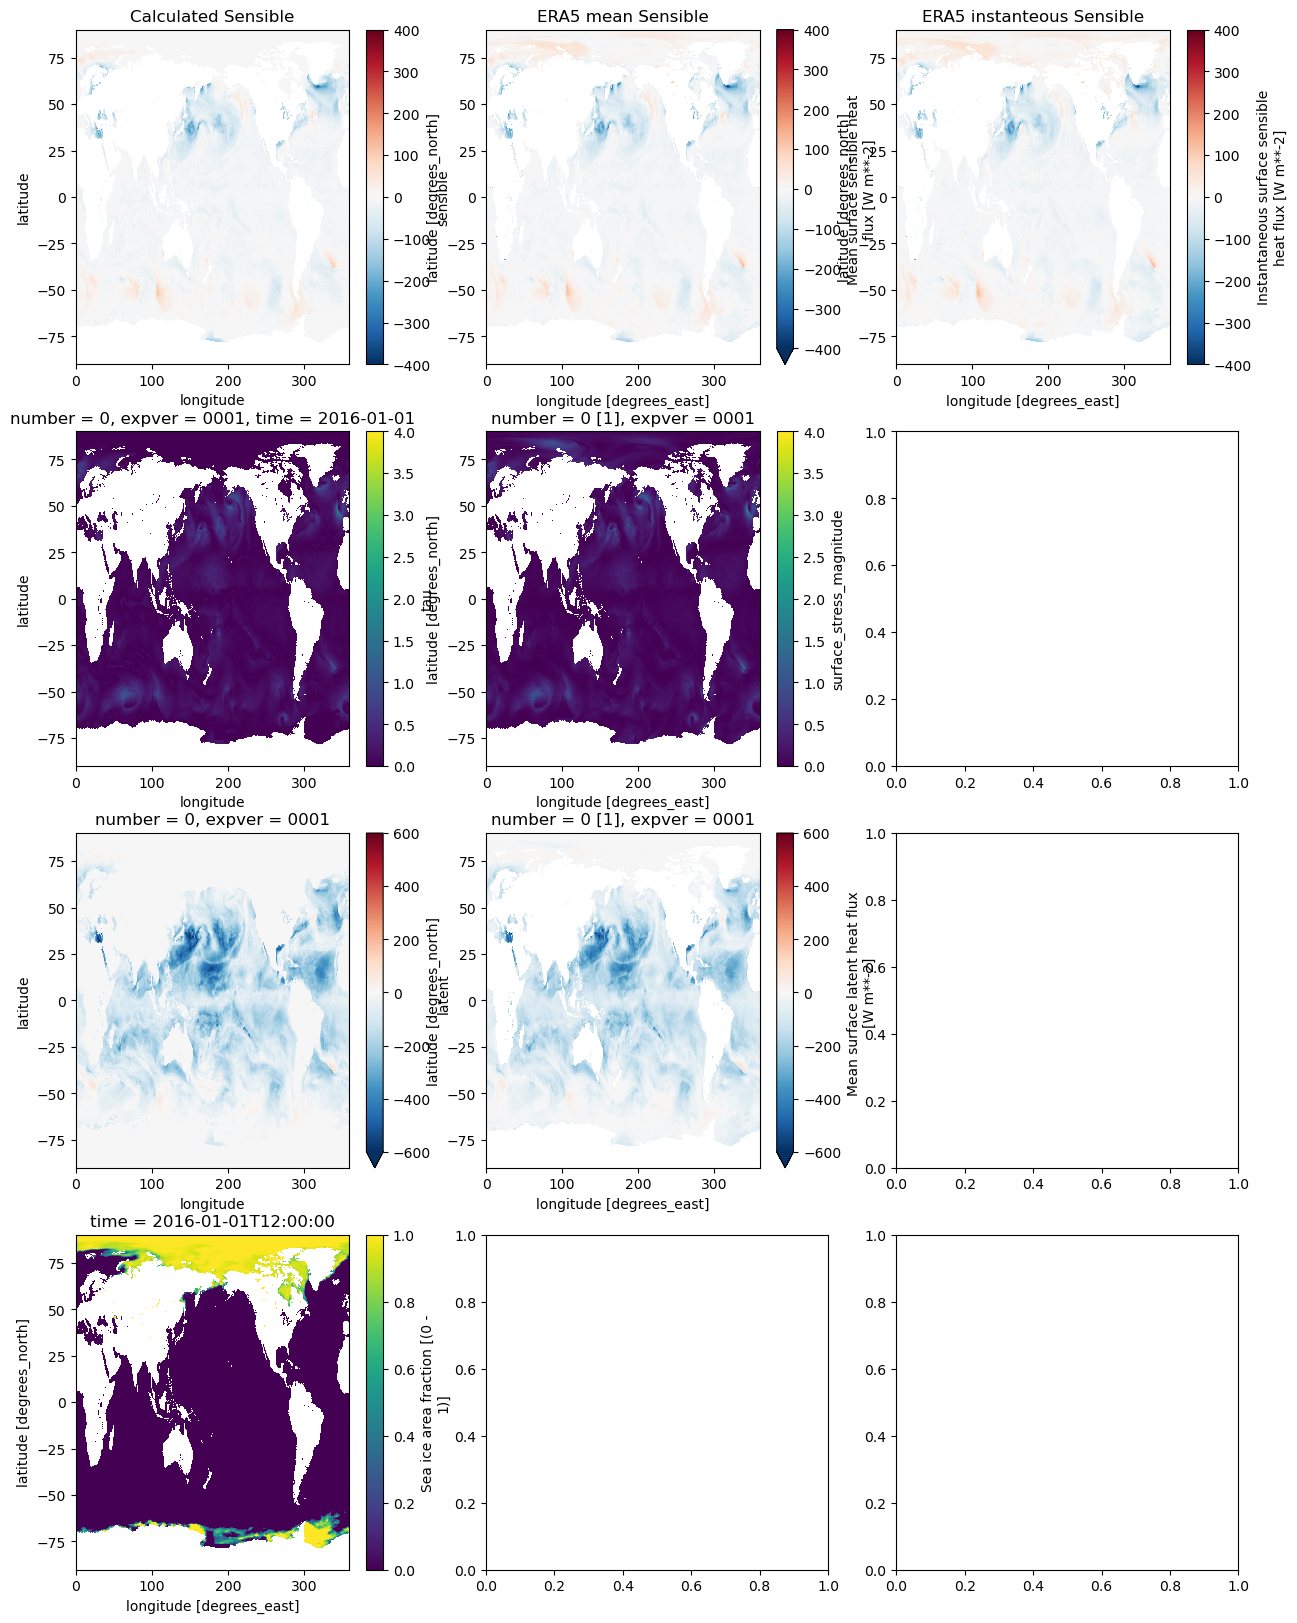

In [89]:
num_rows = 4
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
res_sst_ds['sensible'].where(sea_mask).plot.imshow(cmap='RdBu_r', ax=ax[0,0], vmin=-400, vmax=400)
ax[0,0].set_title('Calculated Sensible')

sshf_da = ds['msshf'].where(sea_mask)
sshf_da.plot.imshow(ax=ax[0,1], vmin=-400, vmax=400, cmap='RdBu_r',)
ax[0,1].set_title('ERA5 mean Sensible')

sshf_da = ds['ishf'].where(sea_mask)
sshf_da.plot.imshow(ax=ax[0,2], vmin=-400, vmax=400, cmap='RdBu_r',)
ax[0,2].set_title('ERA5 instanteous Sensible')


res_sst_ds['tau'].where(sea_mask).plot.imshow(ax=ax[1,0], vmin=0, vmax=4)
tau_da = ds['surface_stress_magnitude'].where(sea_mask)
tau_da.plot.imshow(ax=ax[1,1], vmin=0, vmax=4)

res_sst_ds['latent'].plot.imshow(ax=ax[2,0], vmin=-600, vmax=600, cmap='RdBu_r',)
tau_da = ds['mslhf'].where(sea_mask)
tau_da.plot.imshow(ax=ax[2,1], vmin=-600, vmax=600, cmap='RdBu_r',)

ds['siconc'].plot.imshow(ax=ax[3,0])


## Sensible heat flux

Text(0.5, 1.0, 'Exp factor with ERA5 h')

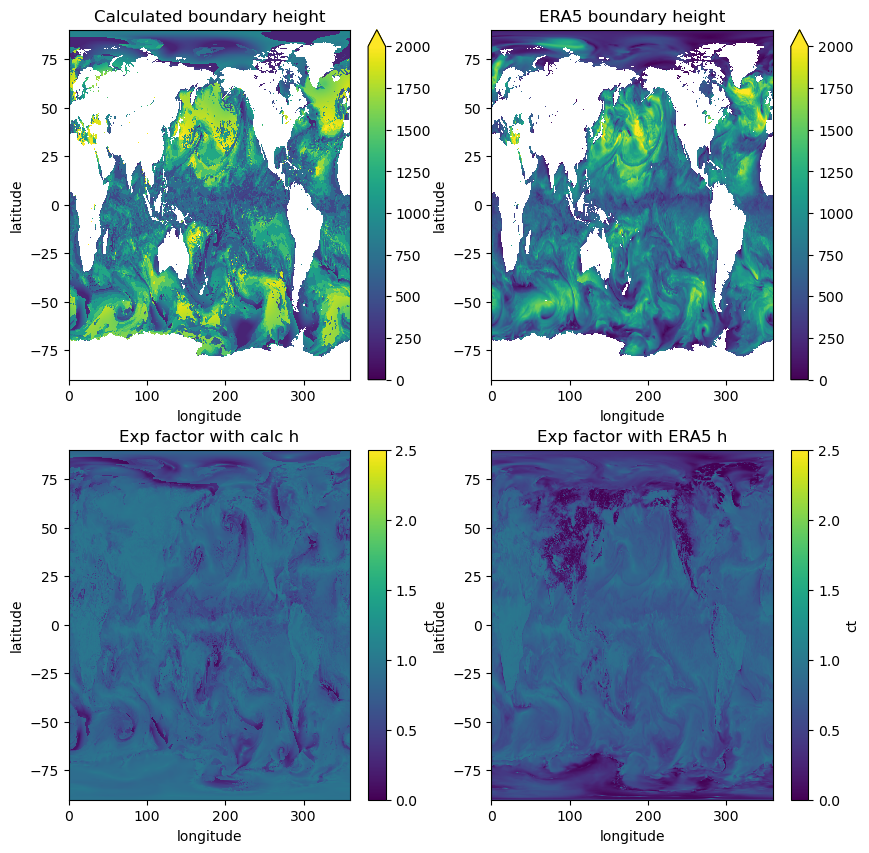

In [22]:
num_rows = 2
num_cols = 2
entrainment_coefficient = 0.2
delta_t = 6*60*60

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))

xr.where(sea_mask, height_da, np.nan).plot(ax=axs[0,0], vmin=0, vmax=2000)
xr.where(sea_mask, ds['blh'], np.nan).plot(ax=axs[0,1], vmin=0, vmax=2000)

exponential_factor_with_bl = np.exp( -  (1 + entrainment_coefficient) * delta_t * np.divide(np.multiply(res_sst_ds['ct'], ds['surface_wind_magnitude']) , height_da)  )
exponential_factor = np.exp( -  (1 + entrainment_coefficient) * delta_t * np.divide(np.multiply(res_sst_ds['ct'], ds['surface_wind_magnitude']) , ds['blh'])  )


exponential_factor_with_bl.plot.imshow(ax=axs[1,0], vmin=0, vmax=2.5)
exponential_factor.plot(ax=axs[1,1], vmin=0, vmax=2.5)

axs[0,0].set_title('Calculated boundary height')
axs[0,1].set_title('ERA5 boundary height')
axs[1,0].set_title('Exp factor with calc h')
axs[1,1].set_title('Exp factor with ERA5 h')

Text(0.5, 1.0, 'ERA5 boundary height')

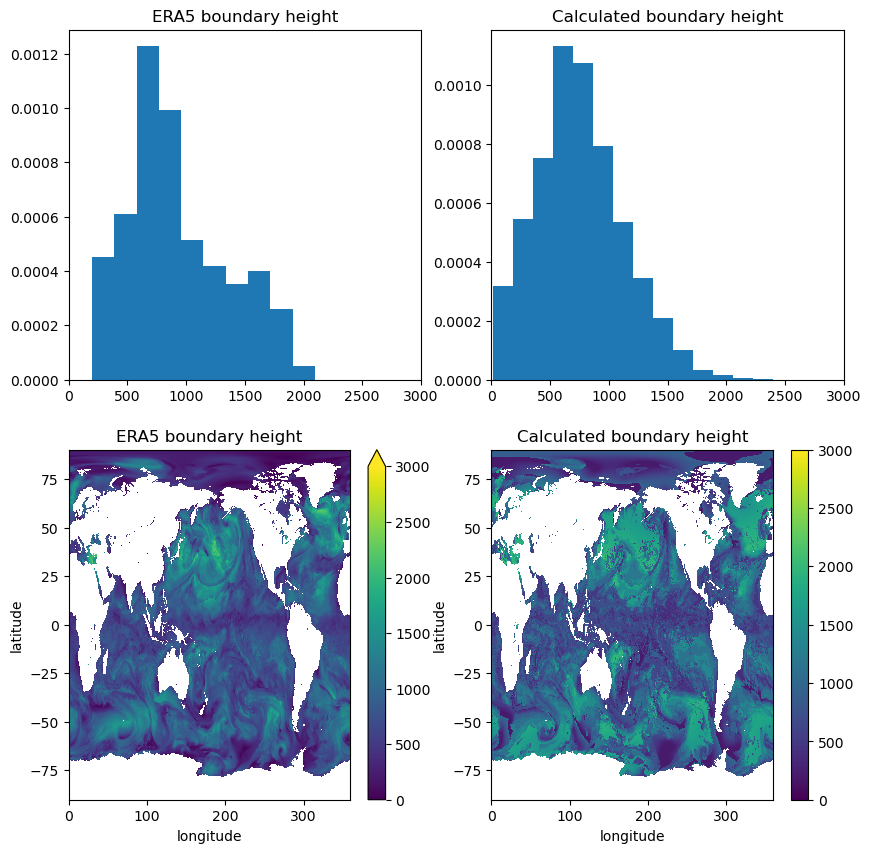

In [23]:
num_rows = 2
num_cols = 2
entrainment_coefficient = 0.2
delta_t = 6*60*60 # 6 hours

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))

# plot boundary layer height distribution
xr.where(sea_mask, height_da, np.nan).plot.hist(ax=axs[0,0], bins=10, density=True)
axs[0,0].set_xlim([0,3000])
xr.where(sea_mask, ds['blh'], np.nan).plot.hist(bins=20, ax=axs[0,1], density=True)
axs[0,1].set_xlim([0,3000])


xr.where(sea_mask, ds['blh'], np.nan).plot(ax=axs[1,0], vmin=0, vmax=3000)
xr.where(sea_mask, height_da, np.nan).plot(ax=axs[1,1], vmin=0, vmax=3000)

axs[0,0].set_title('ERA5 boundary height')
axs[0,1].set_title('Calculated boundary height')
axs[1,1].set_title('Calculated boundary height')
axs[1,0].set_title('ERA5 boundary height')

In [24]:
def calculate_sensible_heat_flux(rho, cp, ct, t_surf, t_air, u_magnitude):

    return  np_multiply_many([rho, cp, ct, t_air - t_surf, u_magnitude])

In [15]:
num_rows = 2
num_cols = 2

entrainment_coefficient = 0.2
prefactor = 1.0
delta_t = 6*60*60 * prefactor
mixed_layer_depth = 20 # To be replaced with NEMO MLD
sea_density = 1.03 # To be replaced, use potential density?
ocean_heat_capacity = 4200
cp = res_sst_ds['cp']
skin_temp = sea_surface_ds['sea_surface_temperature'] -  res_sst_ds['dter'] - res_sst_ds['dtwl'] #TODO: Get NEMO to pass skin temperature instead

# Calculate equilibrium temperature
ocean_eqm_factor = sea_density * ocean_heat_capacity * mixed_layer_depth
atm_eqm_factor = np_multiply_many([height_da ,res_sst_ds['rho'], res_sst_ds['cp']])

t_eqm_numerator = np.multiply(ocean_eqm_factor , skin_temp) + np.multiply(atm_eqm_factor , ds['2m_temperature'])
t_eqm_denominator = ocean_eqm_factor + atm_eqm_factor

t_eqm = np.divide(t_eqm_numerator, t_eqm_denominator)

# Calculate exponential coefficients
# Currently making lots of simplifications of the ocean which should be checked!
# But since it is to calculate an equilibrium temperature perhaps it is not too important
exp_coeff_atm = np.clip((1 + entrainment_coefficient) * np.divide(np.multiply(res_sst_ds['ct'], ds['surface_wind_magnitude']) , height_da), a_min=1e-8, a_max=None)
exp_coeff_oce = np.clip( np_multiply_many([res_sst_ds['cp'], ds['surface_wind_magnitude'], res_sst_ds['ct'], res_sst_ds['rho']]) / (sea_density * ocean_heat_capacity * mixed_layer_depth), a_min=1e-8, a_max=None)


In [16]:
# Calculate new temperature, and temperature change
new_t = (ds['2m_temperature'] - t_eqm) * np.exp( - (exp_coeff_atm + exp_coeff_oce) * delta_t) + t_eqm


update = np.multiply(t_eqm, (1 - np.exp( - (exp_coeff_atm + exp_coeff_oce) * delta_t))) +  np.multiply(ds['2m_temperature'], np.exp( - (exp_coeff_atm + exp_coeff_oce) * delta_t) - 1)

effective_shf = np.divide(np_multiply_many([new_t - t_eqm, res_sst_ds['rho'], res_sst_ds['cp'], -1 * np.exp(- (exp_coeff_atm + exp_coeff_oce) * delta_t ), (exp_coeff_atm + exp_coeff_oce), height_da]),  1+ entrainment_coefficient)

In [27]:
Q_H = calculate_sensible_heat_flux(rho=res_sst_ds['rho'], ct=res_sst_ds['ct'], cp=res_sst_ds['cp'], u_magnitude=ds['surface_wind_magnitude'], t_air=ds['2m_temperature'], t_surf= skin_temp)

In [28]:
# Calculate the total energy transferred to oceean, via sensible heat flux

# effective_shf = np_multiply_many([ np.divide(1.0, (exp_coeff_atm + exp_coeff_oce)), Q_H, (1 + np.exp( - (exp_coeff_atm + exp_coeff_oce) * delta_t )), ])
# effective_shf = np_multiply_many([ np.divide(1.0, (exp_coeff_atm + exp_coeff_oce)), Q_H, (1 - np.exp( - (exp_coeff_atm + exp_coeff_oce) * delta_t )) ]) / delta_t
effective_shf = - np_multiply_many([update, res_sst_ds['rho'], res_sst_ds['cp'], height_da]) / delta_t

Text(0.5, 1.0, 'Naive change due to sensible heat flux')

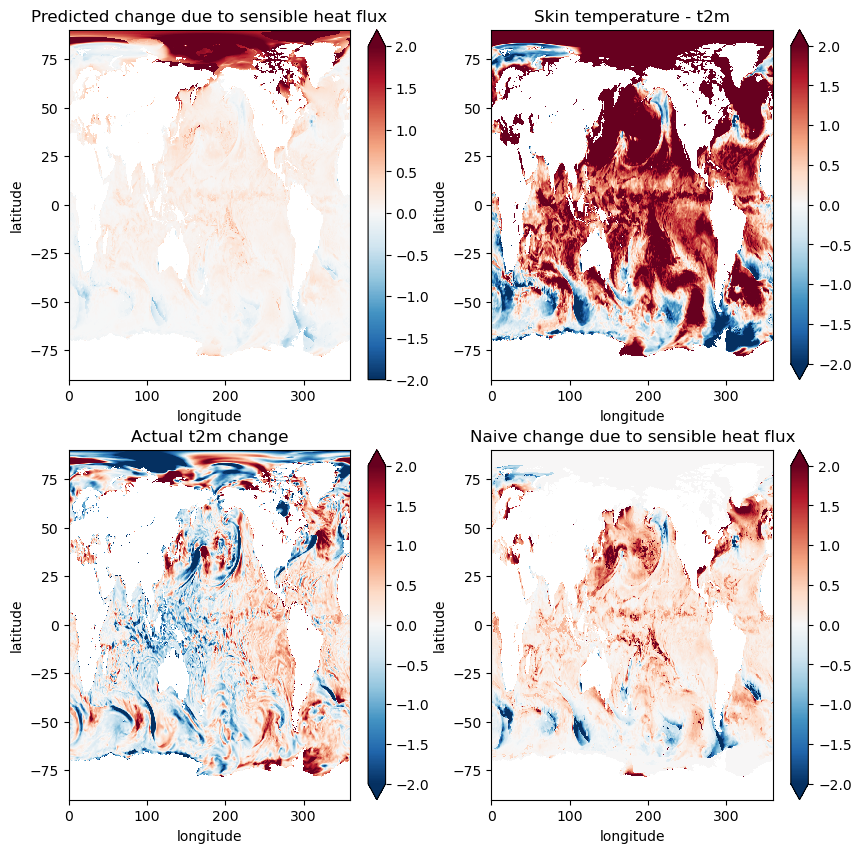

In [20]:
num_rows = 2
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))

temp_diff = ds['2m_temperature'] - skin_temp

xr.where(sea_mask, update, np.nan).plot(ax=axs[0,0], vmin=-2, vmax=2, cmap='RdBu_r')

xr.where(sea_mask, -temp_diff, np.nan).plot(ax=axs[0,1], vmin=-2, vmax=2, cmap='RdBu_r')
xr.where(sea_mask, surface_ds['t2m'].sel(time=dt+datetime.timedelta(hours=6)) - surface_ds['t2m'].sel(time=dt), np.nan).plot(ax=axs[1,0], vmin=-2, vmax=2, cmap='RdBu_r')

# AirSeaFluxCode results define sensible heat flux as positive when going from atmosphere to ocean, so multiply by -1 to get the flux going from ocean to atmosphere
naive_t2m_change = xr.where(sea_mask, -1* (1+entrainment_coefficient)* np.divide(res_sst_ds['sensible']*delta_t, np_multiply_many([res_sst_ds['rho'], res_sst_ds['cp'], height_da])), np.nan)
naive_t2m_change.plot(ax=axs[1,1],vmin=-2, vmax=2, cmap='RdBu_r')

axs[0,0].set_title('Predicted change due to sensible heat flux')
axs[0,1].set_title('Skin temperature - t2m')
axs[1,0].set_title('Actual t2m change')
axs[1,1].set_title('Naive change due to sensible heat flux')

Text(0.5, 1.0, 'AirSeaFluxCode heat flux')

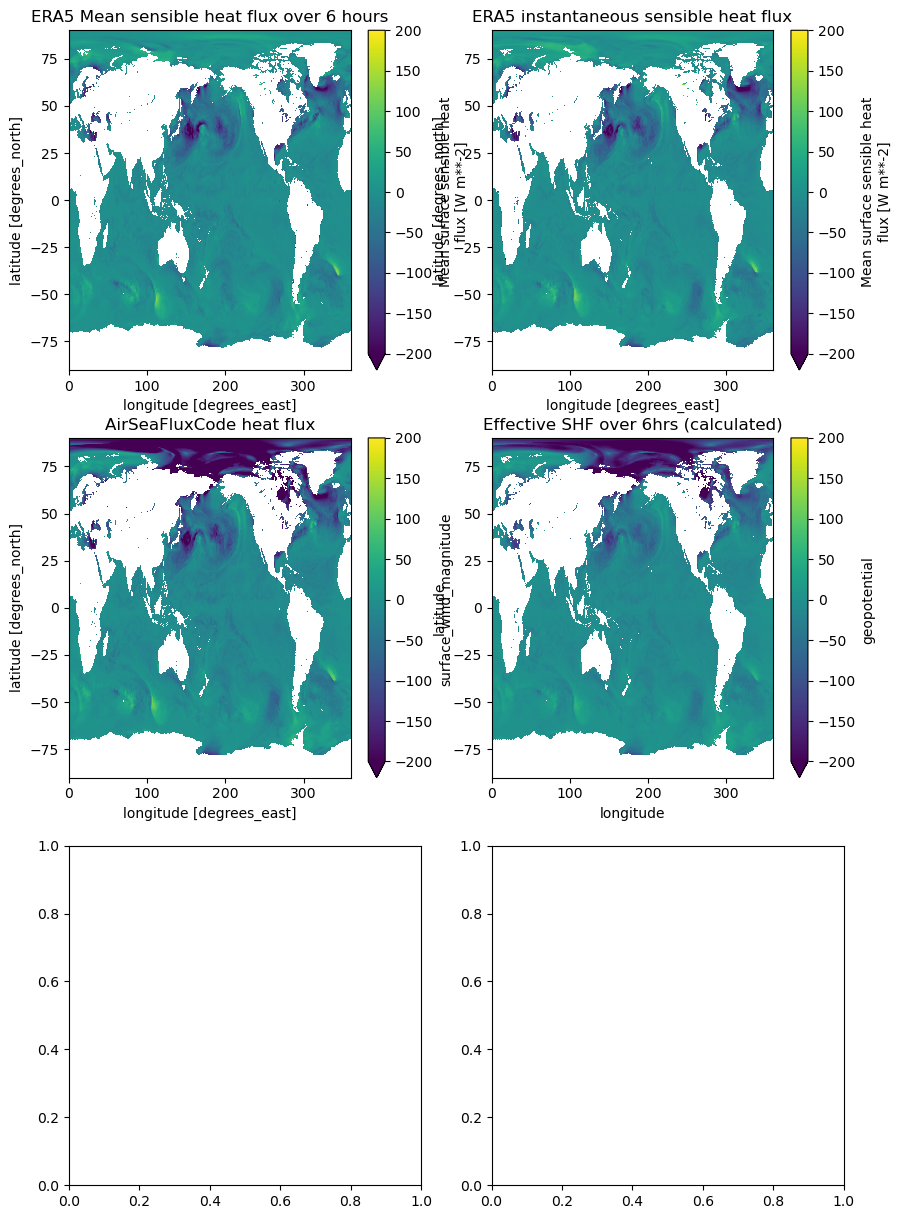

In [47]:
num_cols = 2
num_rows = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))

# effective_shf =  np_multiply_many([ np.divide(1.0, (exp_coeff_atm + exp_coeff_oce)), Q_H, (1 + np.exp( - (exp_coeff_atm + exp_coeff_oce) * delta_t)), ])

# ERA5 heat fluxes are positive downwards.
ds['msshf_6hr'].where(sea_mask).plot(ax=axs[0,0], vmin=-200, vmax=200)
ds['msshf'].where(sea_mask).plot(ax=axs[0,1], vmin=-200, vmax=200)
Q_H.where(sea_mask).plot(ax=axs[1,0], vmin=-200, vmax=200, cmap='viridis')

# res_sst_ds['sensible'].where(sea_mask).plot(ax=axs[1,0], vmin=-200, vmax=200)

(effective_shf).plot(ax=axs[1,1], vmin=-200, vmax=200, cmap='viridis')


axs[0,0].set_title('ERA5 Mean sensible heat flux over 6 hours')
axs[0,1].set_title('ERA5 instantaneous sensible heat flux')
axs[1,1].set_title('Effective SHF over 6hrs (calculated)')
axs[1,0].set_title('AirSeaFluxCode heat flux')

In [ ]:
figure, axs = plt.subplots(3,1)

skin_temp.plot(ax=axs[0], vmax=310, vmin=255)
sea_surface_ds['sea_surface_temperature'].plot(ax=axs[1], vmax=310, vmin=255)
(skin_temp - sea_surface_ds['sea_surface_temperature']).plot(ax=axs[2], vmin=-2, vmax=2, cmap='RdBu_r')

In [ ]:
figure, axs = plt.subplots(4,1)

t_eqm.plot(ax=axs[0], vmax=310, vmin=255)
(t_eqm - ds['2m_temperature']).plot(ax=axs[1],  cmap='RdBu_r', vmax=-2, vmin=2)
(t_eqm - skin_temp).plot(ax=axs[2], vmin=-2, vmax=2, cmap='RdBu_r')
xr.where( np.logical_or(np.logical_and(t_eqm > ds['2m_temperature'], t_eqm > skin_temp), np.logical_and(t_eqm < ds['2m_temperature'], t_eqm < skin_temp)), 1,0).plot(ax=axs[3])

## Specific humidity

In [15]:
from src import hum_subs

In [ ]:
qsat_sea(T, P, qmeth)

In [21]:
from src import hum_subs



def saturation_vapour_pressure(T: np.ndarray,
                               phase: str):
    """
    Calculate saturation vapour pressure
    From IFS documentation

    Args:
        T (np.ndarray): temperature (K)
        phase (str): phase of water (water or ice)

    Returns:
        np.ndarray: saturation vapour pressure (hPa)
    """
    # 

    # Temperate T in 

    T0 = 273.16 

    if phase == 'ice':
        a1 = 6.1121 # In units of hPa
        a3 = 22.587
        a4 = -0.7 
    elif phase == 'water':
        a1 = 6.1121 # In units of hPa
        a3 = 17.502
        a4 = 32.19 
    else:
        raise ValueError("Unrecognised phase")

    sat_vap_pres = a1 * np.exp( a3 * np.divide(T - T0 , T - a4))

    # In units of hPa
    return sat_vap_pres

def q_saturation_specific(skin_temp: np.ndarray,
                          sea_level_pressure: np.ndarray, 
                          sea_ice_conc: np.ndarray):
    
    """Calculate saturation specific humidity of air
    Method taken from IFS documentation

    skin_temp: skin temperature (K)
    sea_level_pressure: pressure (hPa)
    sea_ice_conc: sea ice concentration (no units)
    
    Returns:
        np.ndarray: saturation specific humidity (kg/kg)
    """

    # From IFS documentation:
    # q_sat = ( (R_dry / R_vap) * e_sat ) / (  pressure - (1  -  (R_dry / R_vap) ) * e_sat)
    
    R_dry = 287.05       # Specific gas constant for dry air              [J/K/kg]
    R_vap = 461.495      # Specific gas constant for water vapor          [J/K/kg]
    molar_mass_ratio = R_dry / R_vap

    saturation_vapour_pressure_water = saturation_vapour_pressure(skin_temp, 'water')
    saturation_vapour_pressure_ice = saturation_vapour_pressure(skin_temp, 'ice')

    saturation_vapor_press = np.multiply(1 - sea_ice_conc, saturation_vapour_pressure_water) + np.multiply(sea_ice_conc, saturation_vapour_pressure_ice) 

    qsat = np.divide(molar_mass_ratio * saturation_vapor_press, sea_level_pressure - (1 - molar_mass_ratio) * saturation_vapor_press)

    return qsat

In [12]:
delta_t = 6*60*60

In [30]:
R_dry = 287.05       # Specific gas constant for dry air              [J/K/kg]
R_vap = 461.495      # Specific gas constant for water vapor          [J/K/kg]
molar_mass_ratio = R_dry / R_vap

saturation_vapour_pressure_water = saturation_vapour_pressure(skin_temp, 'water')
saturation_vapour_pressure_ice = saturation_vapour_pressure(skin_temp, 'ice')

saturation_vapor_press = np.multiply(1 - sea_ice_conc, saturation_vapour_pressure_water) + np.multiply(sea_ice_conc, saturation_vapour_pressure_ice) 

qsat = np.divide(molar_mass_ratio * saturation_vapor_press, sea_level_pressure - (1 - molar_mass_ratio) * saturation_vapor_press)

NameError: name 'sea_ice_conc' is not defined

In [14]:
import AirSeaFluxCode

ModuleNotFoundError: No module named 'AirSeaFluxCode'

In [13]:
# First need to calculate q_s the saturation specific humidity of air
qsat = q_saturation_specific(skin_temp.values, ds['mean_sea_level_pressure'] / 100 , ds['siconc'].values)

NameError: name 'skin_temp' is not defined

In [22]:
# Naive calculation of evaporation rate
# evaporation = np_multiply_many([res_sst_ds['rho'], res_sst_ds['cq'],   ds['specific_humidity_surface'] - res_sst_ds['qsea']*0.001, ds['surface_wind_magnitude']])
evaporation = np.divide(res_sst_ds['latent'], res_sst_ds['lv'])

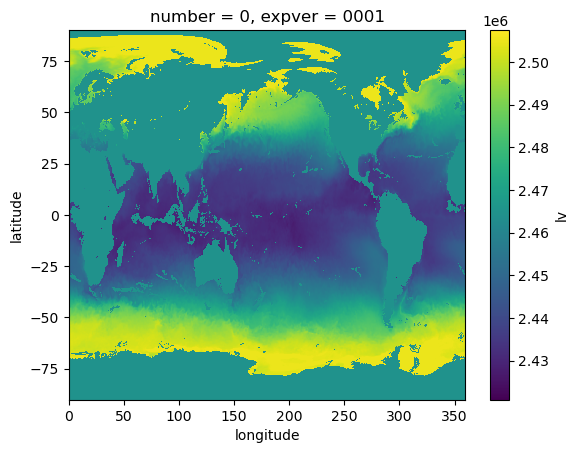

In [23]:
res_sst_ds['lv'].plot()

Text(0.5, 1.0, 'ERA5 mean latent flux')

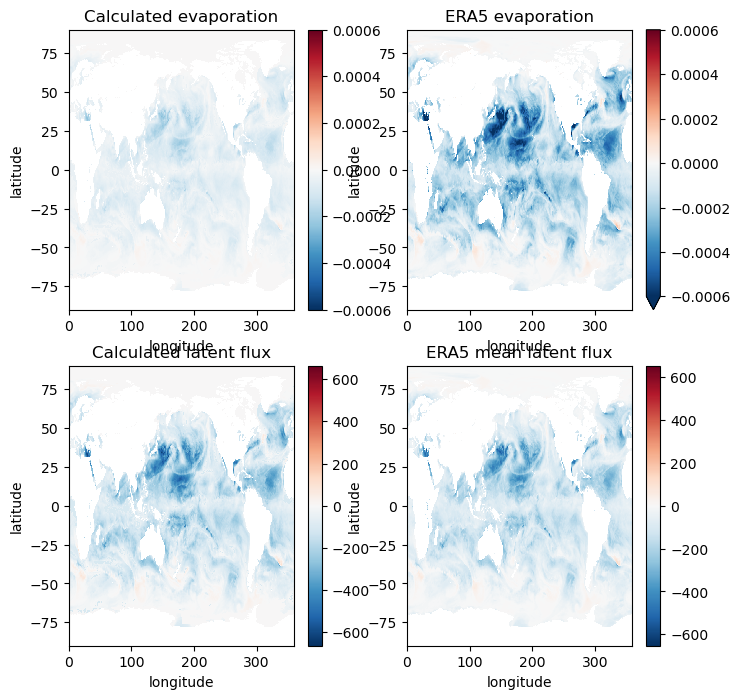

In [32]:
# Compare to ERA5 evaporation
fig, axs = plt.subplots(2,2, figsize=(8,8))

xr.where(sea_mask, evaporation, np.nan).plot(ax=axs[0,0], vmax=0.0006, vmin=-0.0006, cmap='RdBu_r')

xr.where(sea_mask, ds['e'], np.nan).plot(ax=axs[0,1], vmax=0.0006, vmin=-0.0006, cmap='RdBu_r')

xr.where(sea_mask, res_sst_ds['latent'], np.nan).plot(ax=axs[1,0],cmap='RdBu_r')
xr.where(sea_mask, ds['mslhf'], np.nan).plot(ax=axs[1,1],cmap='RdBu_r')

# qsat.plot(ax=axs[1,0])

axs[0,0].set_title('Calculated evaporation')
axs[0,1].set_title('ERA5 evaporation')
axs[1,0].set_title('Calculated latent flux')
axs[1,1].set_title('ERA5 mean latent flux')

In [36]:
# Naive calculation of humidity change
q_change_naive = - delta_t * np.divide( res_sst_ds['latent'],  np_multiply_many([height_da, res_sst_ds['rho'],  res_sst_ds['lv']]))

(array([8.82875299e-07, 0.00000000e+00, 0.00000000e+00, 8.82875299e-07,
        0.00000000e+00, 0.00000000e+00, 8.82875299e-07, 1.76575060e-06,
        4.41437650e-06, 5.29725180e-06, 8.82875299e-07, 1.76575060e-06,
        7.94587769e-06, 5.20896427e-05, 3.54915870e-04, 2.12508085e-03,
        1.52596167e-02, 1.02445318e-01, 3.84911559e-01, 5.78424581e-02]),
 array([-39.88408274, -38.10793352, -36.3317843 , -34.55563508,
        -32.77948586, -31.00333664, -29.22718742, -27.45103821,
        -25.67488899, -23.89873977, -22.12259055, -20.34644133,
        -18.57029211, -16.79414289, -15.01799367, -13.24184445,
        -11.46569523,  -9.68954601,  -7.91339679,  -6.13724757,
         -4.36109835]),
 <BarContainer object of 20 artists>)

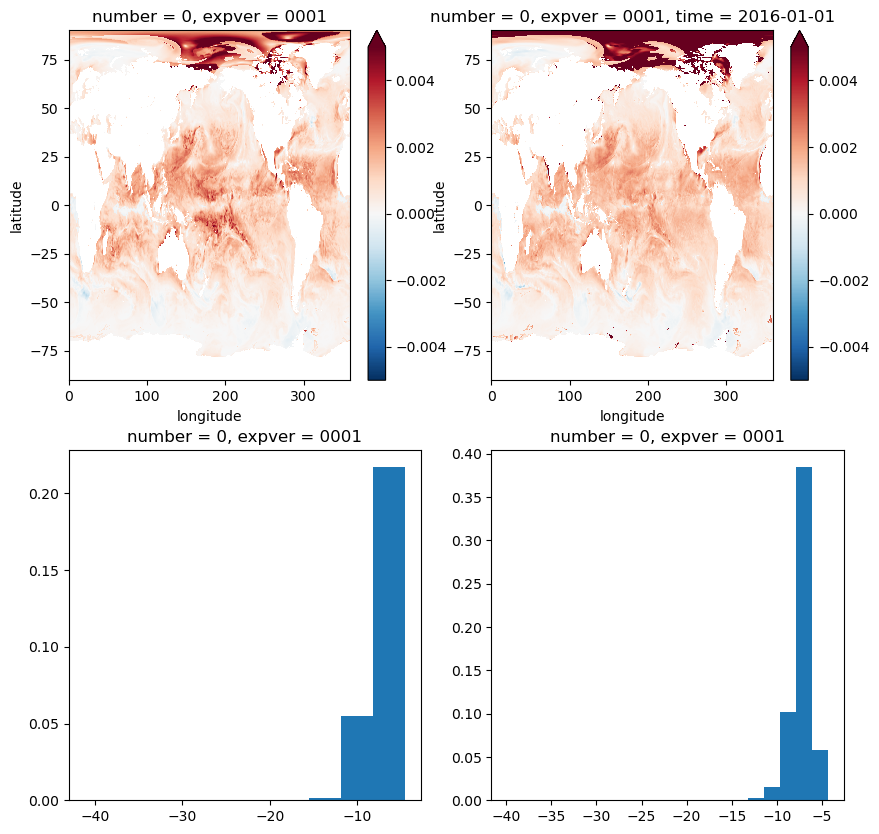

In [34]:
height_da, pressure_da = heuristic_boundary_layer_height(ds)
height_da = np.clip(height_da, a_min=200, a_max=None)
smoothed_height_vals = ndimage.uniform_filter(height_da.fillna(height_da.mean()).values, 3)

# Complicated version
exp_coeff = np.divide(res_sst_ds['cq'] * ds['surface_wind_magnitude'].values, smoothed_height_vals)
exp_coeff_era5 = np.divide(res_sst_ds['cq'] * ds['surface_wind_magnitude'].values, ds['blh'])

exponential_factor = np.clip(np.exp(- exp_coeff * delta_t), a_max=1.0, a_min=0)
exponential_factor_era5 = np.clip(np.exp(- exp_coeff_era5 * delta_t), a_max=1.0, a_min=0)

# Just a weighted average of qsea and the surface specific humidity
q = np.multiply(res_sst_ds['qsea']*0.001, ( 1 -  exponential_factor)) + np.multiply(exponential_factor,  ds['specific_humidity_surface'] )
q_era5 = np.multiply(res_sst_ds['qsea']*0.001, ( 1 -  exponential_factor_era5)) + np.multiply(exponential_factor_era5,  ds['specific_humidity_surface'] )

update = q - ds['specific_humidity_surface']
update_era5 = q_era5 - ds['specific_humidity_surface']

# multiply by time...

num_rows, num_cols = 2,2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
xr.where(sea_mask, update, np.nan).plot(ax=axs[0,0], cmap='RdBu_r',vmin=-0.005, vmax=0.005)
xr.where(sea_mask, update_era5, np.nan).where(sea_mask).plot(ax=axs[0,1], cmap='RdBu_r',vmin=-0.005, vmax=0.005)

xr.where(sea_mask, np.log(update), np.nan).plot.hist(ax=axs[1,0], bins=10, density=True)
xr.where(sea_mask, np.log(update_era5), np.nan).plot.hist(bins=20, ax=axs[1,1], density=True)

Text(0.5, 1.0, 'Naive humidity change')

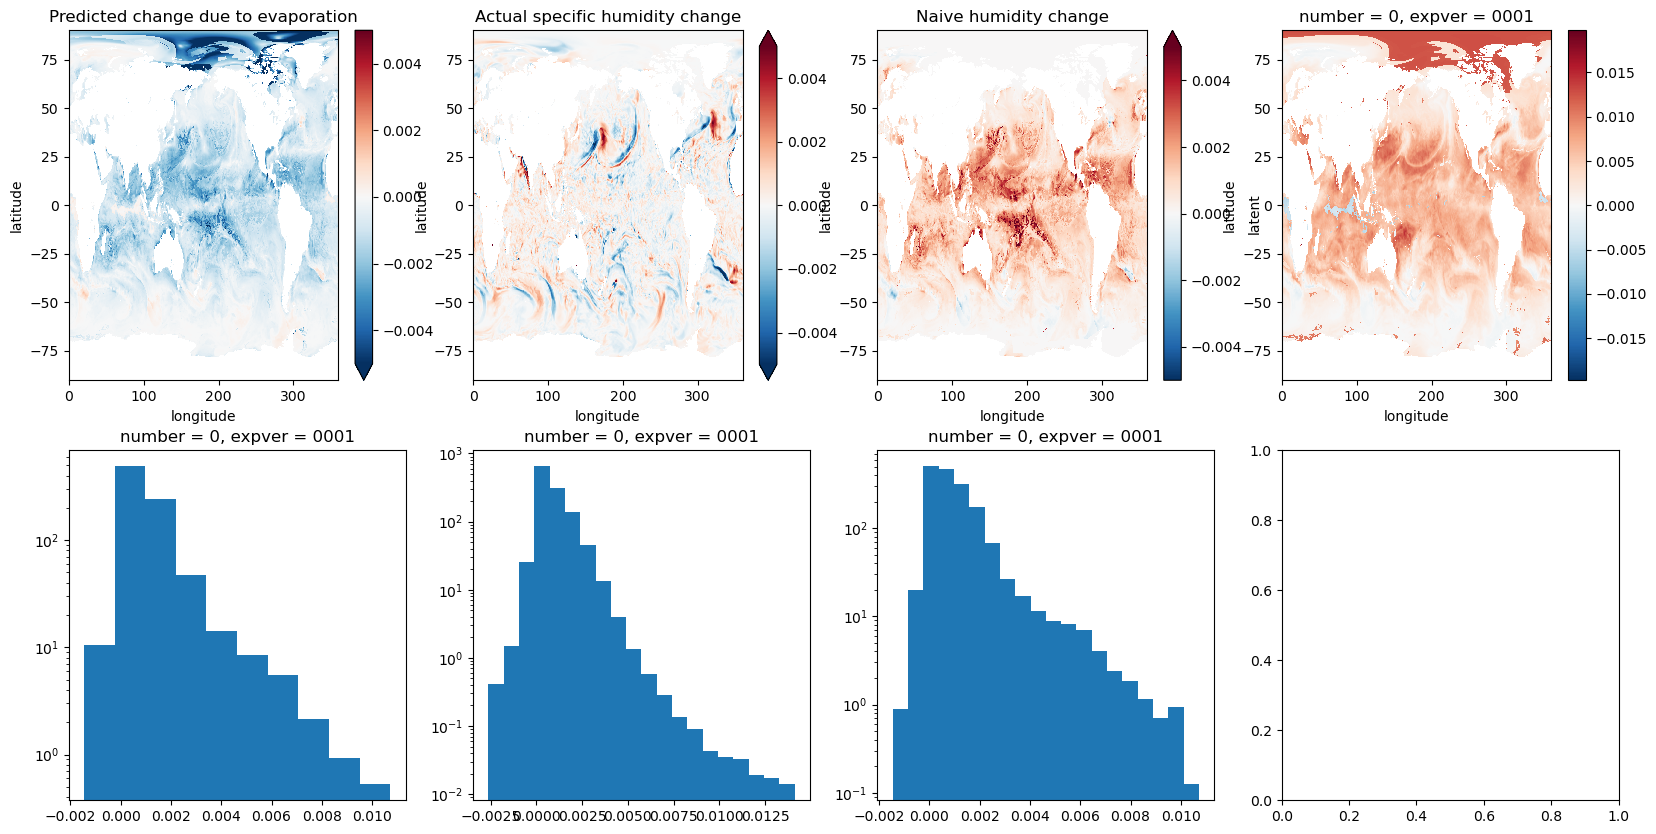

In [41]:
# multiply by time...

num_rows, num_cols = 2,4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))

(-1*update).where(sea_mask).plot(ax=axs[0,0], cmap='RdBu_r',vmin=-0.005, vmax=0.005)

xr.where(sea_mask, plevel_ds['specific_humidity_surface'].sel(time=dt+datetime.timedelta(hours=6)) - plevel_ds['specific_humidity_surface'].sel(time=dt), np.nan).plot(ax=axs[0,1], cmap='RdBu_r', vmin=-0.005, vmax=0.005)

q_change_naive.where(sea_mask).plot(ax=axs[0,2], cmap='RdBu_r', vmin=-0.005, vmax=0.005)

xr.where(sea_mask, res_sst_ds['qsea']*0.001 - ds['specific_humidity_surface'], np.nan).plot(ax=axs[0,3])

# Distribution of values
xr.where(sea_mask, update, np.nan).plot.hist(ax=axs[1,0], bins=10, density=True)
xr.where(sea_mask, q_change_naive, np.nan).plot.hist(bins=20, ax=axs[1,1], density=True)
xr.where(sea_mask, update, np.nan).plot.hist(bins=20, ax=axs[1,2], density=True)

axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[1,2].set_yscale('log')

axs[0,0].set_title('Predicted change due to evaporation')
axs[0,1].set_title('Actual specific humidity change')
axs[0,2].set_title('Naive humidity change')

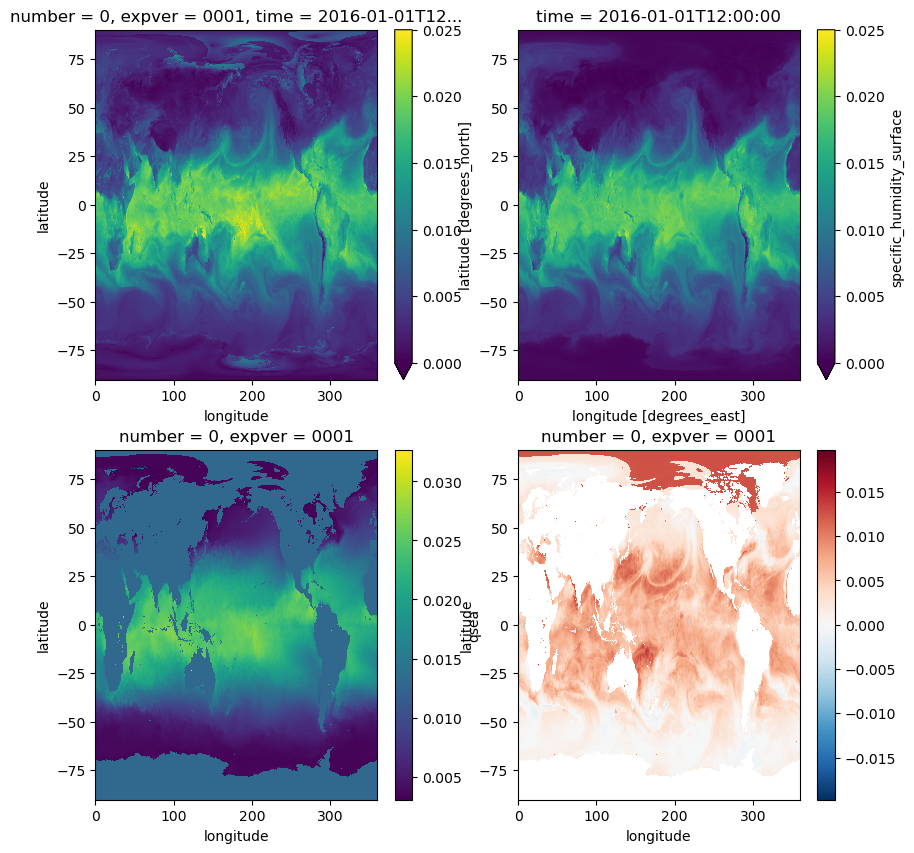

In [178]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

q.plot(ax=axs[0,0], vmin=0, vmax=0.025)

ds['specific_humidity_surface'].plot(ax=axs[0,1], vmin=0, vmax=0.025)

(res_sst_ds['qsea']/1000).plot(ax=axs[1,0])

(res_sst_ds['qsea']/1000 - ds['specific_humidity_surface']).where(sea_mask).plot(ax=axs[1,1])

In [ ]:
# Total evaporation
tot_evap = exponential_factor * ( ds['specific_humidity_surface'] - qsat ) * res_sst_ds['cq']

## Momentum flux

In [ ]:
eastward_wind_t0 = ds['10m_u_component_of_wind']
northward_wind_t0 = ds['10m_v_component_of_wind']

wind_magnitude_t0 = np.sqrt(eastward_wind_t0**2 + northward_wind_t0**2) + 1e-6

normalised_eastward_wind_t0 = eastward_wind_t0 / wind_magnitude_t0
normalised_northward_wind_t0 = northward_wind_t0 / wind_magnitude_t0

air_density_over_ocean = ds['air_density_over_ocean']
friction_velocity = ds['zust']

In [55]:
surface_ds['avg_iews'].mean()

<xarray.DataArray 'avg_iews' ()> Size: 4B
np.float32(0.021549983)
Coordinates:
    number   int64 8B 0

In [69]:
height_da.mean(
)

<xarray.DataArray 'geopotential' ()> Size: 4B
np.float32(1021.55383)
Coordinates:
    time     datetime64[ns] 8B 2016-01-01T12:00:00

In [67]:
ds['surface_wind_magnitude']**2

<xarray.DataArray 'cd' ()> Size: 8B
np.float64(0.0013347267560637158)
Coordinates:
    number   int64 8B 0
    expver   <U4 16B '0001'

In [71]:
6*60*60 * 0.001 / 1000

0.0216

In [56]:
np_multiply_many([res_sst_ds['rho'], ds['surface_wind_magnitude']**2, res_sst_ds['cd']]).mean()

<xarray.DataArray 'cd' ()> Size: 8B
np.float64(0.09339404446620792)
Coordinates:
    number   int64 8B 0
    expver   <U4 16B '0001'
    time     datetime64[ns] 8B 2016-01-01T12:00:00

In [79]:
6*60*60*ds['mean_surface_stress_magnitude_6hr'].mean() / (1000)

<xarray.DataArray 'mean_surface_stress_magnitude_6hr' ()> Size: 4B
np.float32(3.2480557)
Coordinates:
    time     datetime64[ns] 8B 2016-01-01T12:00:00

Text(0.5, 1.0, 'Calculated average surface stress')

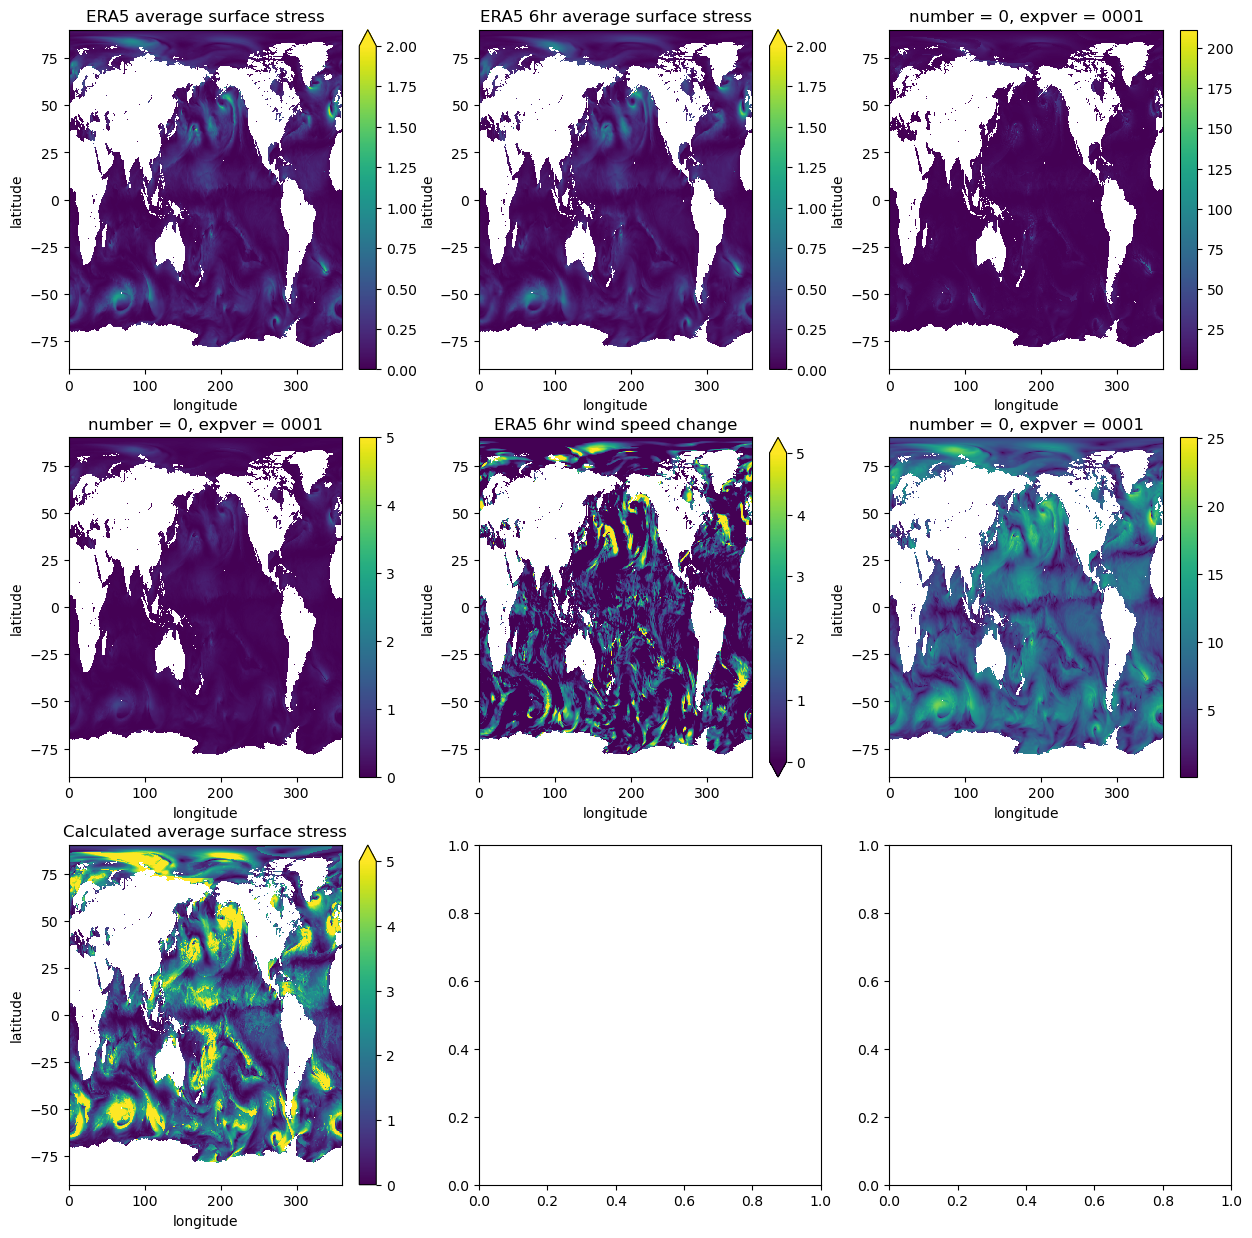

In [84]:
num_rows = 3
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
xr.where(sea_mask, ds['mean_surface_stress_magnitude'], np.nan).plot(ax=ax[0,0], vmin=0, vmax=2)
xr.where(sea_mask, ds['mean_surface_stress_magnitude_6hr'], np.nan).plot(ax=ax[0,1], vmin=0, vmax=2)
xr.where(sea_mask, 6*60*60*np.divide(ds['mean_surface_stress_magnitude_6hr'], np.multiply(res_sst_ds['rho'], height_da)), np.nan).plot(ax=ax[0,2])

xr.where(sea_mask, np_multiply_many([res_sst_ds['rho'], ds['surface_wind_magnitude']**2, res_sst_ds['cd']]), np.nan).plot(ax=ax[1,0], vmin=0, vmax=5)

mmntm_numerator = np.multiply(ds['surface_wind_magnitude']**2 , res_sst_ds['cd']) * delta_t
mmntm_denominator = height_da + np.multiply(ds['surface_wind_magnitude'] , res_sst_ds['cd']) * delta_t
calculated_wind_change = np.divide(mmntm_numerator, mmntm_denominator)

change_in_wind_speed_era5 = surface_ds['surface_wind_magnitude'].sel(time=datetime.datetime(2016, 1, 1, 18, 0)) - surface_ds['surface_wind_magnitude'].sel(time=datetime.datetime(2016, 1, 1, 12, 0))

xr.where(sea_mask, change_in_wind_speed_era5, np.nan).plot(ax=ax[1,1], vmin=0, vmax=5)
ax[1,1].set_title('ERA5 6hr wind speed change')

xr.where(sea_mask, surface_ds['surface_wind_magnitude'].sel(time=datetime.datetime(2016, 1, 1, 12, 0)), np.nan).plot(ax=ax[1,2])

xr.where(sea_mask, calculated_wind_change, np.nan).plot(ax=ax[2,0], vmin=0, vmax=5)
ax[0,0].set_title('ERA5 average surface stress')
ax[0,1].set_title('ERA5 6hr average surface stress')
ax[2,0].set_title('Calculated average surface stress')

Text(0.5, 1.0, 'ERA5 6hr wind speed change')

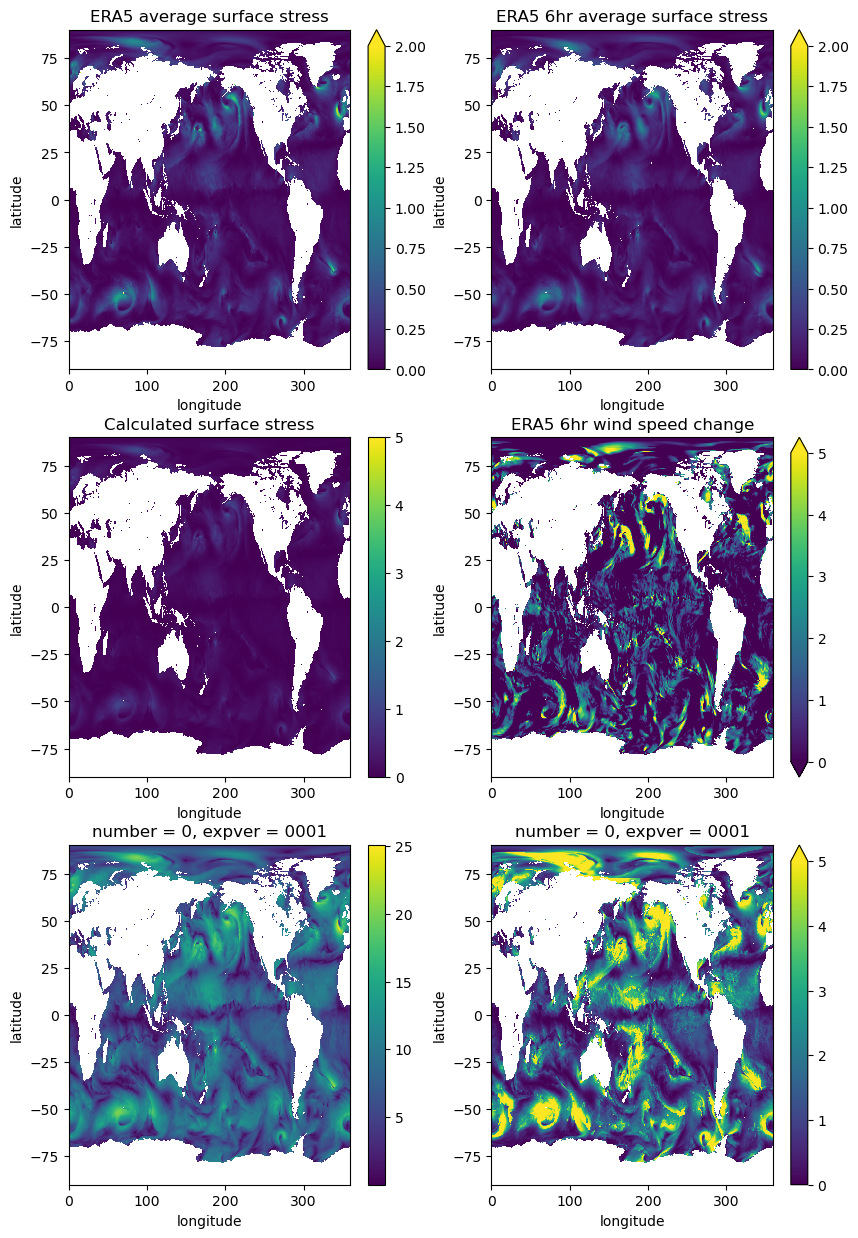

In [76]:
num_rows = 3
num_cols = 2

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
xr.where(sea_mask, ds['mean_surface_stress_magnitude'], np.nan).plot(ax=ax[0,0], vmin=0, vmax=2)
xr.where(sea_mask, ds['mean_surface_stress_magnitude_6hr'], np.nan).plot(ax=ax[0,1], vmin=0, vmax=2)
 
delta_t = 6*60*60 # 6 hours
mmntm_numerator = np.multiply(ds['surface_wind_magnitude']**2 , res_sst_ds['cd']) * delta_t
mmntm_denominator = height_da + np.multiply(ds['surface_wind_magnitude'] , res_sst_ds['cd']) * delta_t

calculated_wind_change = np.divide(mmntm_numerator, mmntm_denominator)

xr.where(sea_mask, np_multiply_many([res_sst_ds['rho'], ds['surface_wind_magnitude']**2, res_sst_ds['cd']]), np.nan).plot(ax=ax[1,0], vmin=0, vmax=5)

change_in_wind_speed_era5 = surface_ds['surface_wind_magnitude'].sel(time=datetime.datetime(2016, 1, 1, 18, 0)) - surface_ds['surface_wind_magnitude'].sel(time=datetime.datetime(2016, 1, 1, 12, 0))

xr.where(sea_mask, change_in_wind_speed_era5, np.nan).plot(ax=ax[1,1], vmin=0, vmax=5)
xr.where(sea_mask, surface_ds['surface_wind_magnitude'].sel(time=datetime.datetime(2016, 1, 1, 12, 0)), np.nan).plot(ax=ax[2,0])
xr.where(sea_mask, calculated_wind_change, np.nan).plot(ax=ax[2,1], vmax=5)

ax[0,0].set_title('ERA5 average surface stress')
ax[0,1].set_title('ERA5 6hr average surface stress')
ax[1,0].set_title('Calculated surface stress')
ax[1,1].set_title('ERA5 6hr wind speed change')

In [ ]:
# Scatter plot between instantaneous heat flux and 

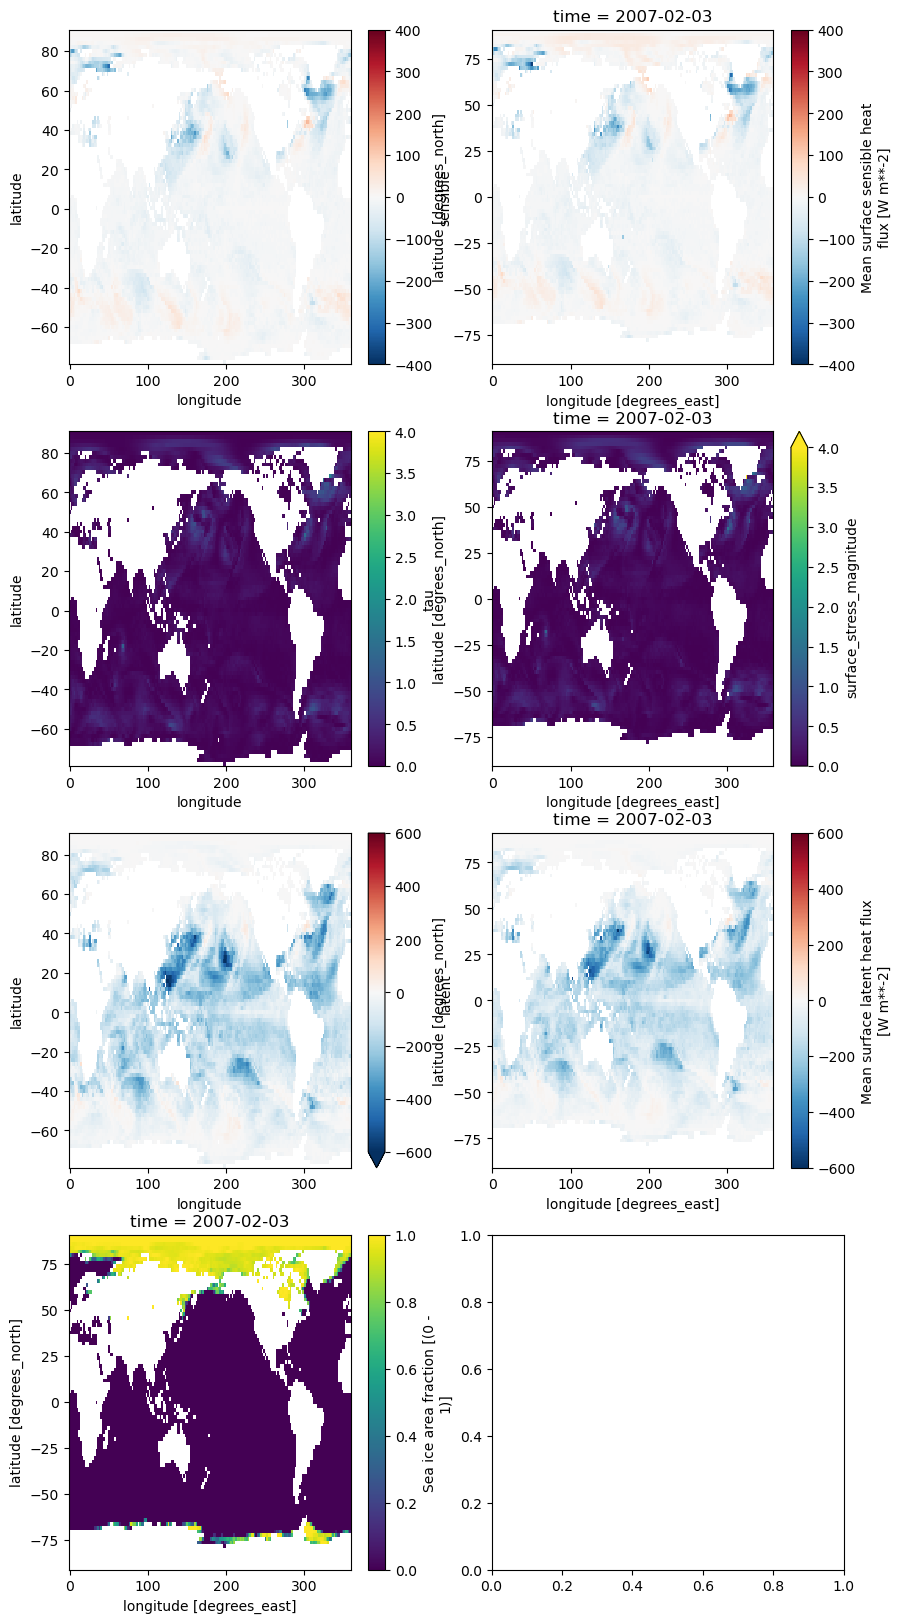

In [343]:
num_rows = 4
num_cols = 2

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
res_2deg_ds['sensible'].plot.imshow(cmap='RdBu_r', ax=ax[0,0], vmin=-400, vmax=400)
sshf_da = ds_2deg['msshf'].where(~ds_2deg['sst'].isnull())
sshf_da.plot.imshow(ax=ax[0,1], vmin=-400, vmax=400, cmap='RdBu_r',)

res_2deg_ds['tau'].plot.imshow(ax=ax[1,0], vmin=0, vmax=4)
tau_da = ds_2deg['surface_stress_magnitude'].where(~ds_2deg['sst'].isnull())
tau_da.plot.imshow(ax=ax[1,1], vmin=0, vmax=4)

res_2deg_ds['latent'].plot.imshow(ax=ax[2,0], vmin=-600, vmax=600, cmap='RdBu_r',)
tau_da = ds_2deg['mslhf'].where(~ds_2deg['sst'].isnull())
tau_da.plot.imshow(ax=ax[2,1], vmin=-600, vmax=600, cmap='RdBu_r',)

ds_2deg['siconc'].plot.imshow(ax=ax[3,0])

(array([6.74653e+05, 1.13180e+04, 3.37000e+02, 4.30000e+01, 5.00000e+00,
        3.00000e+00, 1.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.77088354e-04, 6.26698315e-01, 1.25321960e+00, 1.87974083e+00,
        2.50626206e+00, 3.13278317e+00, 3.75930452e+00, 4.38582563e+00,
        5.01234674e+00, 5.63886786e+00, 6.26538897e+00]),
 <BarContainer object of 10 artists>)

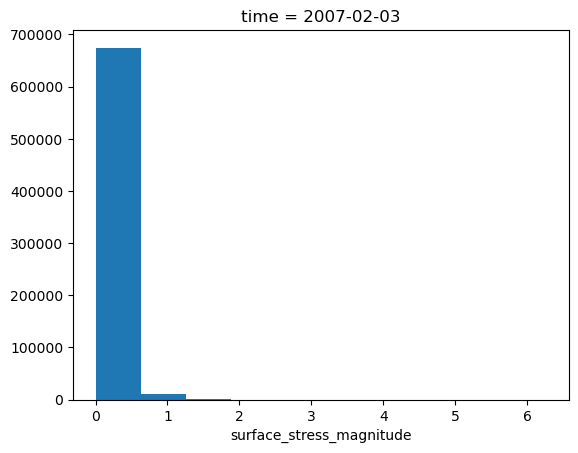

In [289]:
ds['surface_stress_magnitude'].where(~ds['sst'].isnull()).plot.hist()

### AirSeaFluxCode examples

AirSeaFluxCode is set up to run in its default setting with a minimum number of input variables, namely wind speed; air temperature; and sea surface temperature. Let's load the code, import some real data composed for testing it (Research vessel data) and run AirSeaFluxCode with default settings (output height 10m, cool skin/warm layer corrections turned off, bulk algorithm Smith 1988, gustiness on, saturation vapour pressure following Buck (2012), tolerance limits set for both flux estimates and height adjusted variables (['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1]), number of iterations are ten, non converged points are set to missing and Monin-Obukhov stability length is calculated following the ECMWF implementation.

In [22]:
inDt = pd.read_csv("Test_Data/data_all.csv")

In [37]:
inDt = inDt[inDt['Date'] == 20070203]

In [38]:
inDt = pd.read_csv("Test_Data/data_all.csv")
date = np.asarray(inDt["Date"])
lon = np.asarray(inDt["Longitude"])
lat = np.asarray(inDt["Latitude"])
spd = np.asarray(inDt["Wind speed"])
t = np.asarray(inDt["Air temperature"])
sst = np.asarray(inDt["SST"])
rh = np.asarray(inDt["RH"])
p = np.asarray(inDt["P"])
sw = np.asarray(inDt["Rs"])
hu = np.asarray(inDt["zu"])
ht = np.asarray(inDt["zt"])
hin = np.array([hu, ht, ht])
del inDt
outvar = ("tau", "sensible", "latent", "u10n", "t10n", "q10n")
# run AirSeaFluxCode

increase_factor=100
res_baseline = AirSeaFluxCode(spd, 
                     t, 
                     sst, 
                     "bulk", 
                     meth="UA", 
                     lat=lat, 
                     hin=hin, 
                     hum=["rh", rh], 
                     hout=10.3,
                     P=p, 
                     cskin=0, 
                     Rs=sw,
                     tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], L="tsrv", 
                     out_var = outvar)

In [36]:
t

array([27.205, 26.725, 20.799, ..., 13.066, 27.777, 28.142])

In [38]:
np.abs(res['sensible']).max()

np.float64(54.304244463585405)

In [13]:
hu

array([10.3, 10.3, 30.9, ..., 14.2, 10.6, 10.6])

In [14]:
ht

array([10.3, 10.3, 21.7, ..., 14. , 10.6, 10.6])

In [4]:
increase_factor = 100
res = AirSeaFluxCode(np.concat([spd]*increase_factor), 
                     np.concat([t]*increase_factor), 
                     np.concat([sst]*increase_factor), 
                     "bulk", 
                     meth="UA", 
                     lat=np.concat([lat]*increase_factor), 
                     hin=np.concat([hin]*increase_factor, axis=1), 
                     hum=["rh", np.concat([rh]*increase_factor)], 
                     P=np.concat([p]*increase_factor),
                     cskin=0, 
                     Rs=np.concat([sw]*increase_factor),
                     tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], L="tsrv", 
                     out_var = outvar)

res is the output of AirSeaFluxCode which is a dataFrame with keys: "tau", "sensible", "latent", "u10n", "t10n", "q10n". Let's plot the flux estimates.

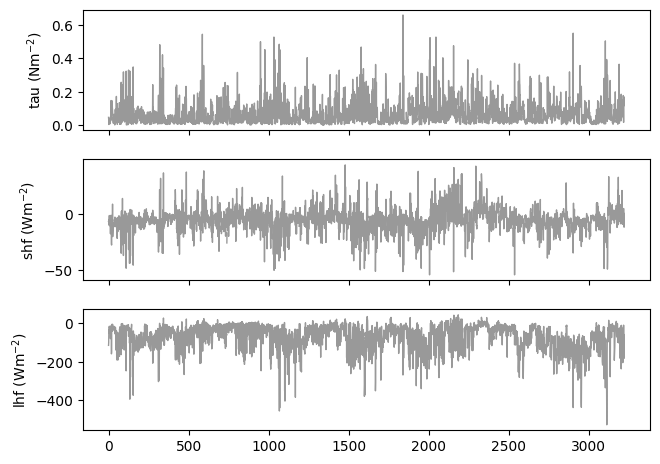

In [5]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False)
fig.tight_layout()
ax[0].plot(res["tau"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[1].plot(res["sensible"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[2].plot(res["latent"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[0].set_ylabel('tau (Nm$^{-2}$)')
ax[1].set_ylabel('shf (Wm$^{-2}$)')
ax[2].set_ylabel('lhf (Wm$^{-2}$)')
plt.show()

You can save the output in a csv file

In [6]:
res.to_csv("test_AirSeaFluxCode.csv")

and generate some statistics which you can save in a txt file

In [7]:
print("Input summary", file=open('./stats.txt', 'a'))
print('input file name: {}, \n method: {}, \n gustiness: {}, \n cskin: {},'
      ' \n tolerance: {}, \n qmethod: {}, \n L: {}'.format("data_all.csv", "UA", "on",
                                                           0, "all", "Buck2", "Rb"),
      file=open('./stats.txt', 'a'))
ttl = np.asarray(["tau  ", "shf  ", "lhf  ", "u10n ", "t10n ", "q10n "])
header = ["var", "mean", "median", "min", "max", "5%", "95%"]
n = np.shape(res)
stats = np.copy(ttl)
a = res.iloc[:,:-1].to_numpy(dtype="float64").T
stats = np.c_[stats, np.nanmean(a, axis=1)]
stats = np.c_[stats, np.nanmedian(a, axis=1)]
stats = np.c_[stats, np.nanmin(a, axis=1)]
stats = np.c_[stats, np.nanmax(a, axis=1)]
stats = np.c_[stats, np.nanpercentile(a, 5, axis=1)]
stats = np.c_[stats, np.nanpercentile(a, 95, axis=1)]
print(tabulate(stats, headers=header, tablefmt="github", numalign="left",
               floatfmt=("s", "2.2e", "2.2e", "2.2e", "2.2e", "2.2e", "2.2e")),
      file=open('./stats.txt', 'a'))
print('-'*79+'\n', file=open('./stats.txt', 'a'))
del a